In [1]:
# pip3 install numpy pandas scipy matplotlib

In [1]:
import os, subprocess
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy import stats
from scipy.optimize import minimize
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
pd.options.mode.chained_assignment = None

## Entropy-optimized scorecards

Setting the random seed ensures reproducibility of the experiment

In [2]:
np.random.seed(seed=2017)

## Artificial portfolio

In [3]:
class Portfolio(object):
    """Class to test various scorecard optimization methods using a fake portfolio"""

    _optim_start = None
    _optim_width = None
    
    _portfolio = None    
    _ratings = None
    _comparison = None
    
    def __init__(self, pdfunc = None, size=1000, classes=10):
        """Initialize the portfolio."""
        if pdfunc is None or not callable(pdfunc):
            raise Exception("Expecting pdfunc to be a function, got %s" % str(type(pdfunc)))
        
        r = DataFrame(np.zeros(shape=(classes,10)))
        r.columns = ['Rating','Count','min_score','max_score','min_pd','max_pd','avg_pd','assigned_pd','class_var','loss']
        r.Rating = np.arange(1,classes+1)           
        
        p = DataFrame(np.zeros(shape=(size,2)))
        p.columns = ['PD','Score_logit']
        p.PD = pdfunc(size) 
        p.Score_logit = -np.log(1/p.PD-1)            
        
        self._portfolio = p
        self._ratings = r
        self._classes = classes

    def update_ratings(self, rating_start, class_width, lossfunc):        
        """Update the rating table."""
        portfolio = self._portfolio
        ratings = self._ratings
        N = self._classes
        
        ratings.min_score.iloc[0] = -np.Inf
        ratings.max_score.iloc[0] = rating_start        
        ratings.max_score.iloc[N-1] = np.Inf
        ratings.max_pd.iloc[N-1] = 1  
                        
        ratings.min_score.iloc[1:] = rating_start+(ratings.Rating-2)*class_width
        ratings.max_score.iloc[1:N-1] = ratings.min_score.iloc[1:N-1]+class_width
        
        ratings.min_pd.iloc[1:] = 1/(1+np.exp(-ratings.min_score[1:]))            
        ratings.max_pd.iloc[:N-1] = 1/(1+np.exp(-ratings.max_score[:N-1]))
        
        ratings.Count.iloc[:] = [np.sum((portfolio.PD >= ratings.min_pd[i]) & (portfolio.PD < ratings.max_pd[i])) for i in range(N)]
        ratings.avg_pd.iloc[:] = [portfolio.PD.loc[(portfolio.PD >= ratings.min_pd[i]) & (portfolio.PD < ratings.max_pd[i])].mean() for i in range(N)]
        ratings.class_var.iloc[:] = [np.var(portfolio.PD.loc[(portfolio.PD >= ratings.min_pd[i]) & (portfolio.PD < ratings.max_pd[i])]) for i in range(N)]
        ratings.fillna(0, inplace=True)
        ratings.class_var = ratings.class_var.apply(lambda x: "%.8f" %x)
                
        ratings.assigned_pd.iloc[:] = ratings.min_pd + (ratings.max_pd-ratings.min_pd)/2            
        ratings.loss.iloc[:] = lossfunc(ratings)
        
        return sum(ratings.loss.iloc[:])
           
    def show_parameter_space(self, ranges, points, lossfunc, name="space", title="Loss function space", save=False):
        """Display a graph of the parameter space given a lossfunc."""
        r1 = np.linspace(ranges[0][0],ranges[0][1],points)
        r2 = np.linspace(ranges[1][0],ranges[1][1],points)
        meshX, meshY = np.meshgrid(r1,r2)
        meshZ = np.zeros(shape=(points, points))

        for i in range(meshX.shape[0]):
            for j in range(meshX.shape[1]):
                meshZ[i,j] = portfolio.update_ratings(meshX[i,j],meshY[i,j],lossfunc)

        fig = plt.figure()    
        ax = Axes3D(fig)
        ax.view_init(elev=45., azim=180)

        ax.set_title(title)
        ax.set_xlabel("First rating upper score")
        ax.set_ylabel("Rating class width")
        ax.set_zlabel("Loss")

        ax.plot_surface(meshX, meshY, meshZ, cmap=cm.gnuplot, antialiased=True, shade=False);

        if save:
            for ii in range(0,3600,1):
                ax.view_init(elev=45., azim=ii/10)        
                plt.savefig("space/{}{}.png".format(name,ii), bbox_inches='tight')

            subprocess.call(['ffmpeg', '-y', '-i', 'space/%s.png' % (name+"%d0"), '-s:v', '700x500', '-c:v', 'libx264', '-profile:v', 'high', '-crf', '20', '-pix_fmt', 'yuv420p', 'space/%s.mp4' % name])
            subprocess.call(['rm','space/%s.png' % (name+"*")])

        return ax

    def show_rating_hist(self):
        """Displays the rating histogram."""
        plt.title("Rating classes")
        plt.xlabel("Class")
        plt.ylabel("Ratings")
        plt.bar(portfolio._ratings.Rating,portfolio._ratings.Count,tick_label=portfolio._ratings.Rating);
        plt.show()
        
    def show_pd_hist(self):
        """Show PD histogram."""
        plt.title("Distribution of probabilities of default in the portfolio")
        plt.xlabel("Probability of default")
        plt.ylabel("Ratings")
        plt.hist(self._portfolio.PD,bins=125)
        plt.show()
        
    def rating_table(self):
        """Show rating table."""
        return self._ratings
        
    def optimize(self,start,width,lossfunc,method='nelder-mead'):
        """Optimize the rating."""
        res = minimize(lambda x: self.update_ratings(x[0],x[1],lossfunc),[start,width], method=method,options={'xtol': 1e-8, 'disp': False})
        
        if not res.success:
            raise Exception("Optimization using %s failed: %s" % (lossfunc, res.message))
        
        self._optim_start = res.x[0]
        self._optim_width = res.x[1]        
        
        return res
    
    def optimize_list(self,params, methods, common_loss):
        """Optimize using all the loss functions in methods."""
        comparison = DataFrame(np.zeros(shape=(len(methods),6)))
        comparison.columns = ['Loss function','Total common loss','Average variance','Total entropy', 'First class', 'Class width']
    
        for i, method in enumerate(methods):
            res = self.optimize(params[0], params[1], method['lossfunc'])
            commloss = np.sum(common_loss(self._ratings))
            summary = self.rating_summary()
            
            print(method['title'])
            portfolio.show_rating_hist()
            
            comparison['Loss function'].iloc[i] = method['title']
            comparison['Total common loss'].iloc[i] = commloss
            comparison['Average variance'].iloc[i] = summary['Average variance'].iloc[0]
            comparison['Total entropy'].iloc[i] = summary['Total entropy'].iloc[0]
            comparison['First class'].iloc[i] = summary['First class'].iloc[0]
            comparison['Class width'].iloc[i] = summary['Class width'].iloc[0]
            
        self._comparison = comparison
        return comparison
    
    def rating_summary(self):
        """Return some rating statistics."""
        summary = DataFrame(np.zeros(shape=(1,5)))
        summary.columns = ['Total loss','Average variance','Total entropy', 'First class', 'Class width']
        ratings = self._ratings
        
        rel = ratings.Count/ratings.Count.sum()
        
        summary['Total loss'][0] = ratings.loss.sum()
        summary['Average variance'][0] = np.sum(ratings.class_var.astype(float)*rel)        
        summary['Total entropy'][0] = -np.sum(ratings.Count.loc[ratings.Count>0]/ratings.Count.sum()*np.log(ratings.Count.loc[ratings.Count>0]/ratings.Count.sum()))
        summary['First class'][0] = self._optim_start
        summary['Class width'][0] = self._optim_width
        
        return summary        
    
    def simulate(self, iterations=1000, seed=4034, subtitle='', rating_metrics=None):
        """Simulate defaults and calculate accuracy ratio."""
        portfolio = self._portfolio
        ratings = self._ratings
                
        if rating_metrics is None:
            raise Exception("No rating metrics provided")
            
        metric_names = []
        for metric in rating_metrics:
            metric_names.append(metric['scorename'])
                                
        simres = DataFrame(np.zeros(shape=(iterations,2+len(rating_metrics))))
        simres.columns = ['Iteration','Default rate'] + metric_names
        simres['Iteration'] = np.linspace(1,iterations+1,iterations)
        simres['Iteration'] = simres['Iteration'].astype(int)
        
        simdata = DataFrame(np.zeros(shape=(portfolio.shape[0],4)))
        simdata.columns = ['Real PD', 'Assigned PD', 'Rating class', 'Default']
        simdata['Real PD'].loc[:] = portfolio['PD'].loc[:]
        simdata['Default'] = simdata['Default'].astype(int)
        
        for i in range(ratings.shape[0]):            
            idx = (simdata['Real PD'] >= ratings['min_pd'].loc[i]) & (simdata['Real PD'] < ratings['max_pd'].loc[i])
            
            simdata['Assigned PD'].loc[idx] = ratings['assigned_pd'].loc[i]
            simdata['Rating class'].loc[idx] = ratings['Rating'].loc[i]
            simdata['Rating class'] = simdata['Rating class'].astype(int)
        
        np.random.seed(seed)
        for i in range(iterations):                        
            simdata['Default'].loc[:] = (np.random.uniform(size=simdata.shape[0]) <= simdata['Assigned PD'].loc[:]).astype(int)
           
            for metric in rating_metrics:
                scorename = metric['scorename']
                scorefunc = metric['scorefunc']
                
                if scorefunc is None or not callable(scorefunc):
                    raise Exception("Scorefunc must be a callable object")
                    
                score,_ = scorefunc(simdata, ratings)
                simres[scorename].loc[i] = score    
                
            simres['Default rate'].loc[i] = simdata['Default'].sum()/simdata['Default'].count()
         
        summary = None
        for metric in rating_metrics:            
            scorename = metric['scorename']
            if metric['show_graph']:
                gdata = simres.loc[:,["Iteration", scorename]].copy()
                gdata.columns = ["Iteration", "Score"]
                self.score_graph(gdata,False,scorename,subtitle) 
                
            newsummary = DataFrame(simres[scorename].describe(percentiles=[0.025,0.05,0.25,0.5,0.75,0.095,0.975]))    
            newsummary.columns = [scorename]
            if summary is None:
                summary = newsummary                
            else:                 
                summary = pd.concat([summary, newsummary], axis=1, join='inner')
           
        return simres, summary
    
    def score_graph(self, simres, hist=False, scorename="accuracy ratio", subtitle=""):
        """Draw AR graph."""
        if subtitle == "":
            plt.title("Empirical distribution of %s" % scorename)
        else:
            plt.title("Empirical distribution of %s\n%s" % (scorename, subtitle))

        plt.xlabel(scorename)
        plt.ylabel("Frequency/density")
        plt.xlim(0,1)

        if hist:
            plt.hist(simres['Score'],bins=100);
        else:
            density = stats.gaussian_kde(simres['Score'])
            dx = np.linspace(simres['Score'].min(),simres['Score'].max(),100)
            density.covariance_factor = lambda : .25
            density._compute_covariance()
            plt.plot(dx,density(dx),lw=2,color="#ec9f00")
            plt.fill_between(dx,density(dx),0,color="#ec9f00",alpha='0.25')       
            plt.show()
    
    def score_graph_compare(self, AR1, AR2, label1="", label2="", scorename="accuracy ratio", subtitle="", hist=False):
        """Compare AR distributions."""
        if subtitle == "":
            plt.title("Empirical distributions of %s" % scorename)
        else:
            plt.title("Empirical distributions of %s\n%s" % (scorename, subtitle))

        plt.xlabel("Score")
        plt.ylabel("Frequency/density")
        plt.xlim(0,1)
        
        colors = iter(["#ec9f00","#1f77b4"])
        labels = iter([label1, label2])

        if hist:
            plt.hist(AR1['Score'],bins=100);
            plt.hist(AR2['Score'],bins=100);
        else:
            for simres in [AR1, AR2]:
                color = next(colors)                
                
                density = stats.gaussian_kde(simres['Score'])
                dx = np.linspace(simres['Score'].min(),simres['Score'].max(),100)
                density.covariance_factor = lambda : .25
                density._compute_covariance()
                plt.plot(dx,density(dx),lw=2, color=color, label=next(labels))
                plt.fill_between(dx, density(dx), 0, color=color, alpha='0.25')
                
        plt.legend();

## Loss functions

In [4]:
def squared_loss(ratings):
    """Calculate squared loss"""
    return (ratings.assigned_pd-ratings.avg_pd)**2*ratings.Count

def rel_loss(ratings):
    """Calculate relative loss."""
    return np.abs(ratings.assigned_pd-ratings.avg_pd)/ratings.assigned_pd*ratings.Count

def entropy_loss(ratings):
    """Calculate entropy loss."""    
    rel = ratings.Count/ratings.Count.sum()    
    entropy = -np.nan_to_num(rel*np.log(np.maximum(1e-10,rel)))
    max_entropy = -np.log(1/ratings.shape[0])        
    
    return -entropy/max_entropy # Maximize entropy

def rel_entropy_loss(ratings):
    """Calculate relative loss adjusted for entropy."""
    rloss = rel_loss(ratings)        
    max_rloss = ratings.max_pd/(ratings.min_pd+(ratings.max_pd-ratings.min_pd)/2)*(ratings.Count.sum()/ratings.shape[0])
    
    entropy = entropy_loss(ratings)        
    
    return rloss/max_rloss+entropy

def stdev_loss(ratings):
    """Calculate standard deviation loss."""   
    return np.sqrt(ratings.class_var.astype(float))*ratings.Count

def rel_stdev_loss(ratings):
    """Calculate relative loss adjusted for standard deviation."""
    rloss = rel_loss(ratings)                
    
    stdev = stdev_loss(ratings)        
    
    return rloss+stdev

def ar_loss_constructor(portfolio, seed, iterations):

    def ar_loss(ratings):
        """Calculate accuracy ratio"""
        data, _ = portfolio.simulateAR(seed=seed, iterations=iterations, show_graph=False);

        return [-data.AR.mean()/ratings.shape[0]]*ratings.shape[0]
    
    return ar_loss

## Metrics

In [5]:
def AR_score(simdata, ratings):
    """Calculate the accuracy ratio.
    
    Higher is better
    """
    classes = ratings.shape[0]

    ardata = DataFrame(np.zeros(shape=(classes+1, 8)))
    ardata.columns = ['Rating class','Total', 'Defaults','Share all', 'Share defaults', 'Share optimal', 'Area defaults', 'Area optimal']

    ardata['Rating class'] = np.linspace(0,classes,classes+1)
    ardata['Rating class'].iloc[0] = classes+1
    ardata['Total'].iloc[1:] =  simdata.groupby('Rating class')['Default'].count()
    ardata['Defaults'].iloc[1:] = simdata.groupby('Rating class')['Default'].sum()

    ardata.sort_values('Rating class',ascending=False, inplace=True)
    ardata['Rating class'].iloc[0] = None

    ardata['Share all'] = ardata['Total'].cumsum()/ardata['Total'].sum()
    ardata['Share defaults'] = ardata['Defaults'].cumsum()/ardata['Defaults'].sum()
    ardata['Share optimal'].iloc[1:] = np.minimum(1,ardata['Total'].cumsum()/ardata['Defaults'].sum())

    area_random = metrics.auc(ardata['Share all'],ardata['Share all'],reorder=True)
    area_model = metrics.auc(ardata['Share defaults'],ardata['Share all'],reorder=True)
    area_optimal = metrics.auc(ardata['Share optimal'],ardata['Share all'],reorder=True)

    AR = (area_model-area_random)/(area_optimal-area_random)

    return AR, ardata

def ROC_score(simdata, ratings):
    """Calculate the ROC score.
    
    Higher is better
    """
    y, x = simdata['Default'], simdata['Assigned PD']
    roc = metrics.roc_auc_score(y, x) 
    rocdata = metrics.roc_curve(y, x)
    return roc, rocdata

def Brier_score(simdata, ratings):
    """Calculate the Brier score.
    
    Lower is better
    """         
    y, x = simdata['Default'], simdata['Assigned PD']
    brier = metrics.brier_score_loss(y, x)

    return brier, None


def Cross_entropy_score(simdata, ratings):
    """Calculate an aggregated cross entropy score.
    
    Lower is better
    """
    
    classes = ratings.shape[0]    

    ardata = DataFrame(np.zeros(shape=(classes, 5)))
    ardata.columns = ['Rating class','Total', 'Defaults','Share defaults', 'Share expected']

    ardata['Rating class'] = ratings['Rating']
    ardata['Total'] =  simdata.groupby('Rating class')['Default'].count()
    ardata['Defaults'] = simdata.groupby('Rating class')['Default'].sum()

    ardata['Share defaults'] = ardata['Defaults']/ardata['Defaults'].sum()        
    ardata['Share expected'] = ratings['assigned_pd']*ardata['Total']/(ratings['assigned_pd']*ardata['Total']).sum()

    ardata.sort_values('Rating class',ascending=False, inplace=True)

    ardata = DataFrame(np.nan_to_num(ardata))
    ardata.columns = ['Rating class','Total', 'Defaults','Share defaults', 'Share expected']
    
    idx = ardata["Share defaults"] > 0
    entropy = -np.sum(ardata["Share defaults"].loc[idx]*np.log(ardata['Share expected'].loc[idx]))

    return entropy, None

## PD models

In [6]:
def pd_normal(size):
    """Draw PDs from a Logistic distribution."""
    loc = -3.75
    scale = 1
    return 1/(1+np.exp(-stats.logistic.rvs(loc=loc, scale=scale, size=size)/scale))

def pd_subprime(size):
    """Draw PDs from a Logistic distribution."""
    loc = 0.25
    scale = 0.1
    return 1/(1+np.exp(-stats.logistic.rvs(loc=loc, scale=scale, size=size)/scale))

def pd_beta(size):
    """Draw PDs from a Beta distribution."""
    return stats.beta.rvs(1.75, 20, size=size)

def pd_bimodal(size):
    """Draw PDs from a bimodal distribution."""
    mu1, sigma1 = -1.2, 0.6
    mu2, sigma2 = 0.5, 0.3
    
    w = stats.binom.rvs(1,0.5,size=size)                        
    n = w*stats.norm.rvs(mu1,sigma1,size=size) + (1-w)*stats.norm.rvs(mu2,sigma2,size=size)    
                            
    return stats.norm.cdf(n)

In [7]:
methods = [
    {'title': "Squared loss", 'lossfunc': squared_loss, 'name': "squared_loss"},
    {'title': "Relative loss", 'lossfunc': rel_loss, 'name': "rel_loss"},
    {'title': "Entropy loss", 'lossfunc': entropy_loss, 'name': "entropy_loss"},
    {'title': "Relative entropy loss", 'lossfunc': rel_entropy_loss, 'name': "rel_entropy_loss"},
    {'title': "Standard deviation loss", 'lossfunc': stdev_loss, 'name': "stdev_loss"},
    {'title': "Relative standard deviation loss", 'lossfunc': rel_stdev_loss, 'name': "rel_stdev_loss"}
]

# Case study 1 - normal portfolio

In [8]:
portfolio = Portfolio(size=1000,pdfunc = pd_normal, classes = 10)
portfolio._portfolio.head(10)

PD  Score_logit
0  0.000503    -7.593946
1  0.071880    -2.558159
2  0.018723    -3.959079
3  0.003213    -5.737311
4  0.240238    -1.151376
5  0.041769    -3.132936
6  0.003835    -5.559728
7  0.007038    -4.949331
8  0.006839    -4.978322
9  0.008198    -4.795683

In [9]:
portfolio._portfolio.describe()

PD  Score_logit
count  1000.000000  1000.000000
mean      0.071310    -3.717450
std       0.131166     1.808551
min       0.000035   -10.265096
25%       0.008040    -4.815266
50%       0.022837    -3.756271
75%       0.065128    -2.664075
max       0.996850     5.757353

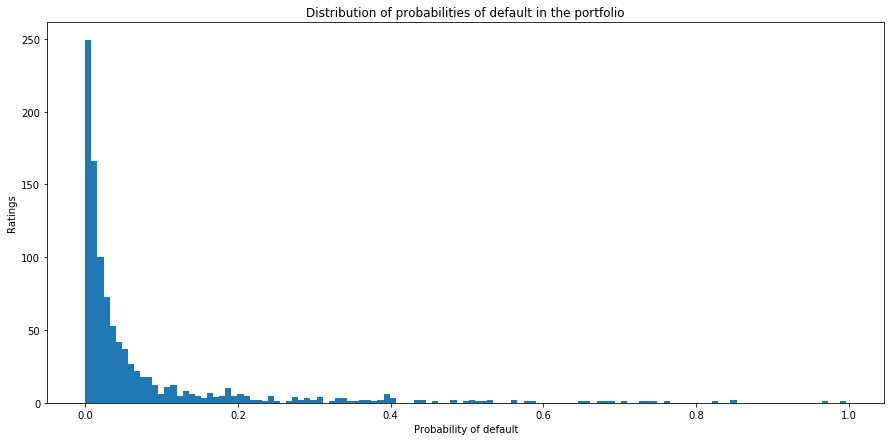

In [11]:
portfolio.show_pd_hist()

## Loss function space

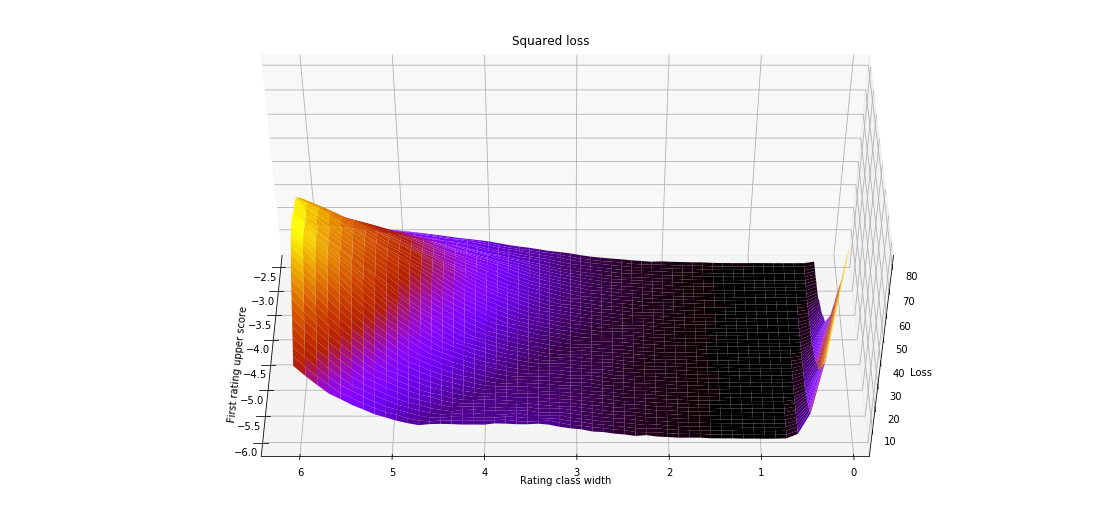

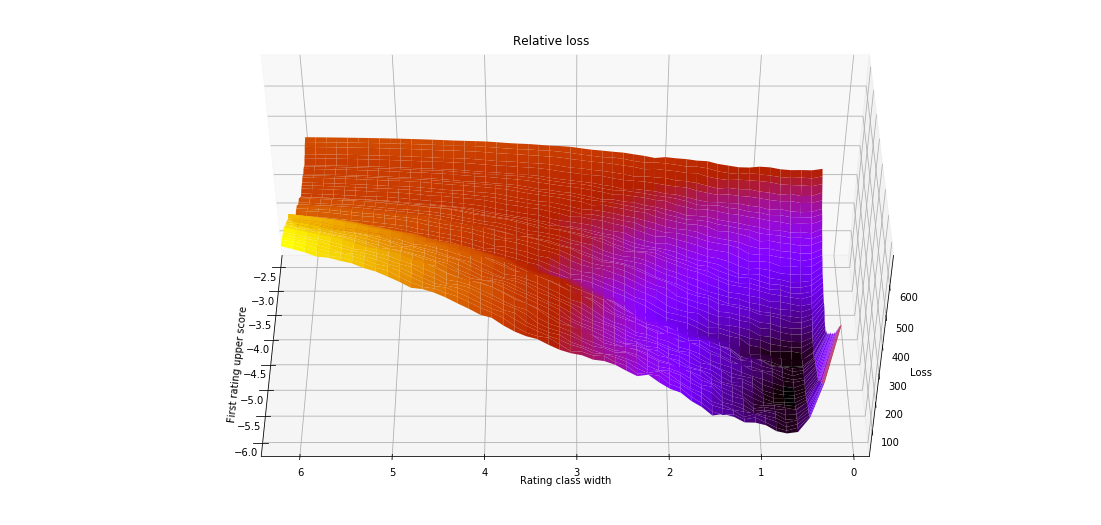

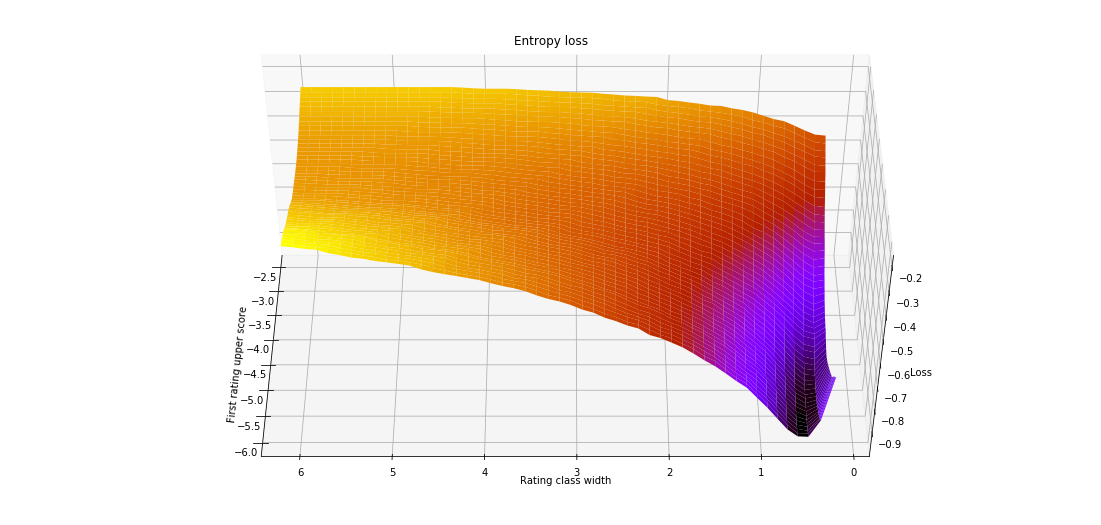

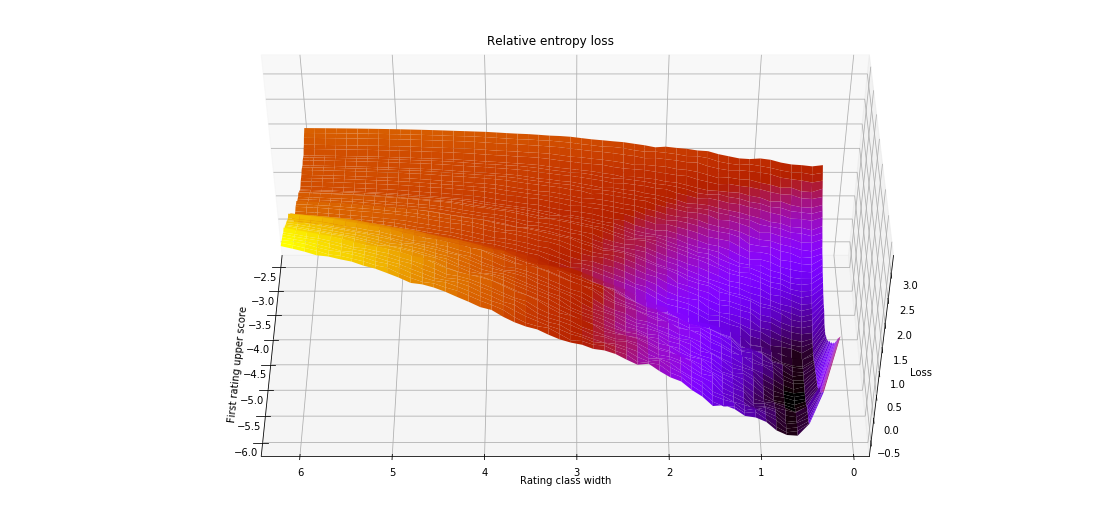

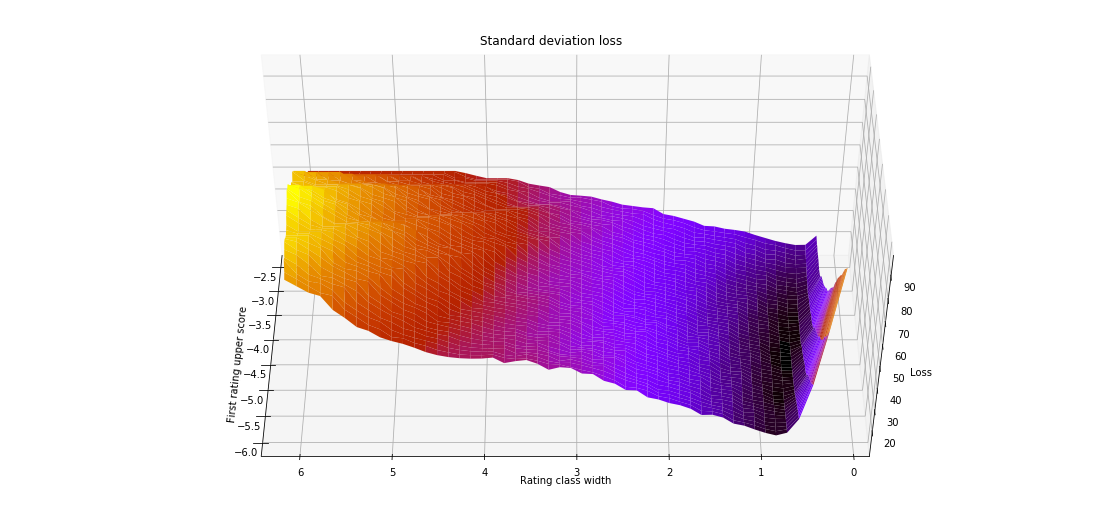

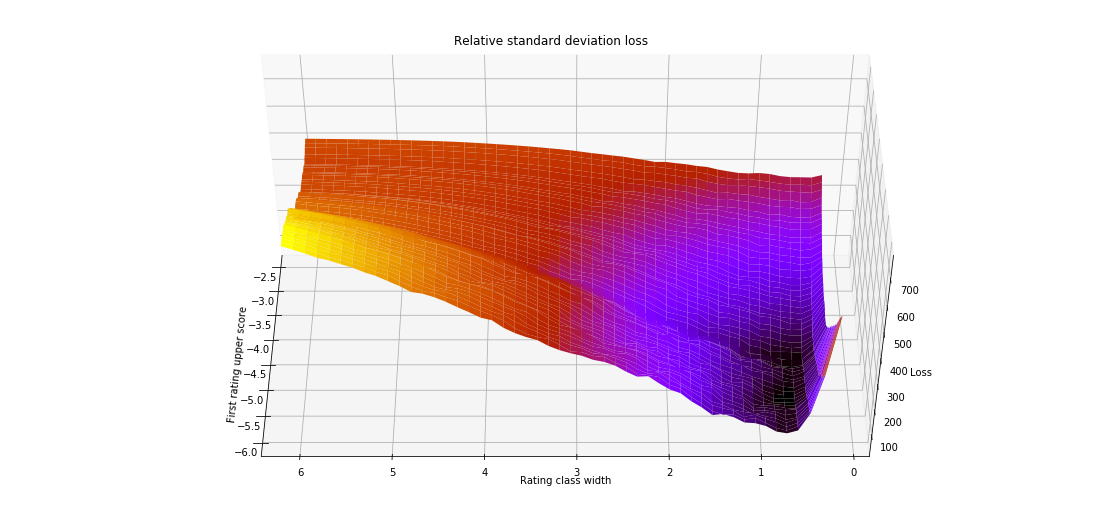

In [12]:
ranges = [[-2.5,-6],[0.25,6]]
points = 50

for method in methods:    
    portfolio.show_parameter_space(ranges, points, method['lossfunc'], name=method['name'], title=method['title'], save=False);

## Optimizing all loss functions

In [100]:
np.random.seed(seed=2017)
portfolio = Portfolio(size=1000,pdfunc = pd_normal, classes = 10)

In [101]:
optim_start = [-5.5, 0.5]
common_loss = rel_loss

Squared loss


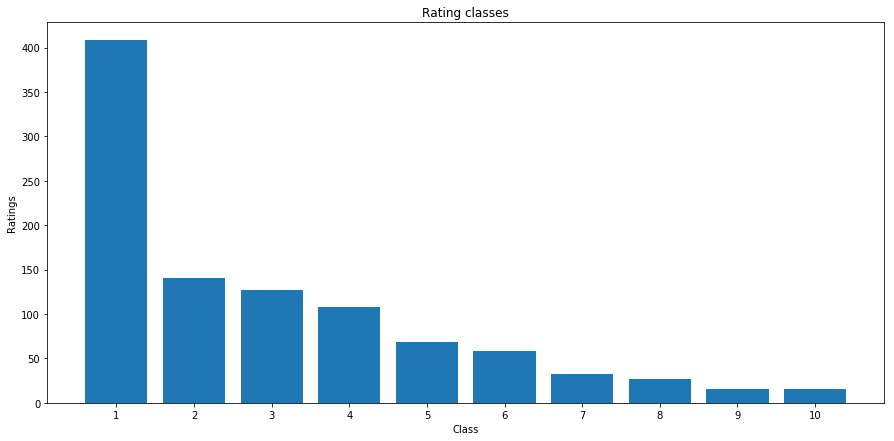

Relative loss


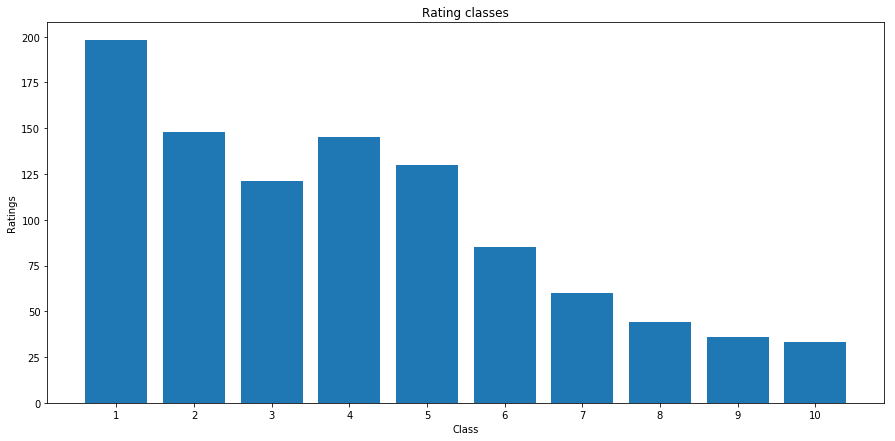

Entropy loss


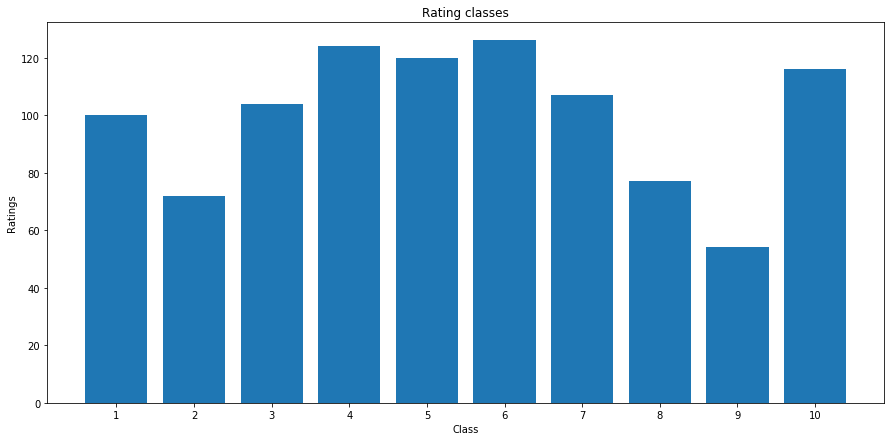

Relative entropy loss


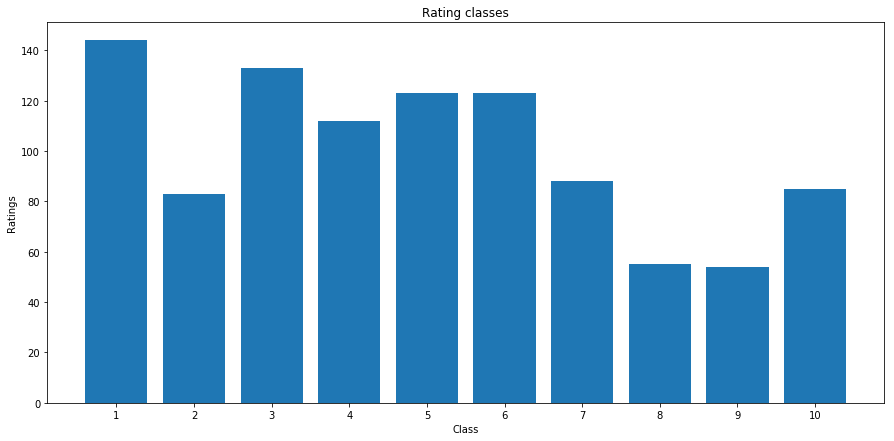

Standard deviation loss


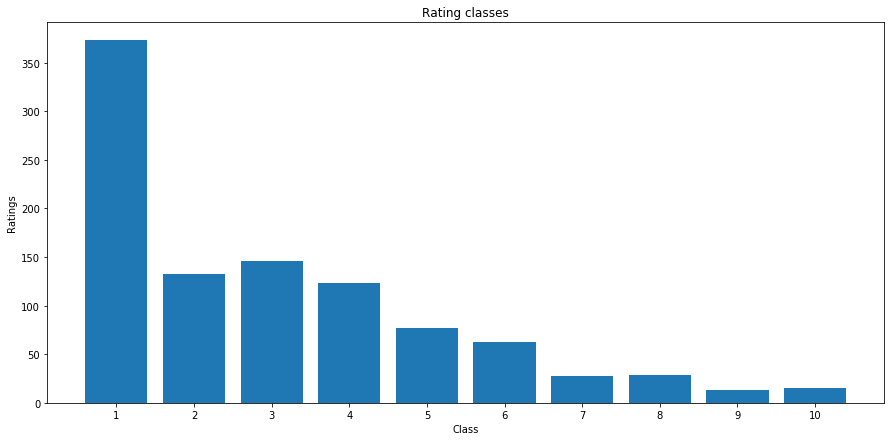

Relative standard deviation loss


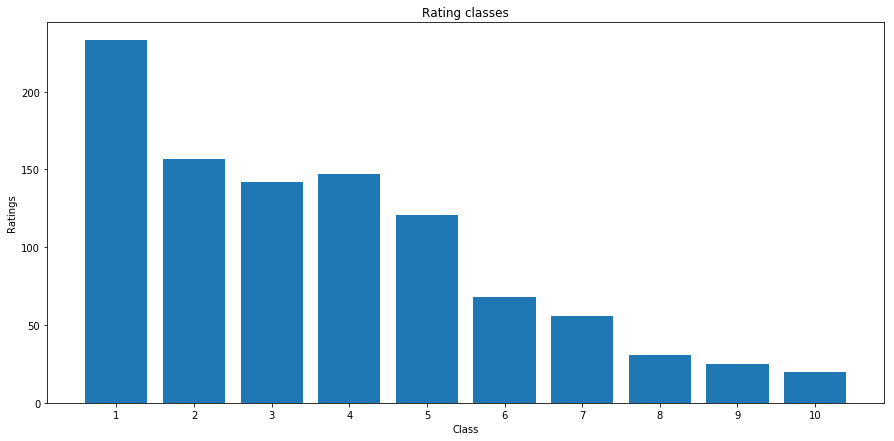

Loss function  Total common loss  Average variance  \
0                      Squared loss          67.344520          0.000327   
1                     Relative loss          26.962885          0.000918   
2                      Entropy loss          71.243124          0.004239   
3             Relative entropy loss          34.264436          0.002921   
4           Standard deviation loss          49.332671          0.000327   
5  Relative standard deviation loss          27.017724          0.000512   

   Total entropy  First class  Class width  
0       1.829196    -4.159078     0.561406  
1       2.152213    -5.094945     0.593345  
2       2.273429    -5.784441     0.526525  
3       2.255213    -5.452359     0.519140  
4       1.868676    -4.346423     0.608459  
5       2.067035    -4.903594     0.628042

In [15]:
optims = portfolio.optimize_list(params = optim_start, methods = methods, common_loss = common_loss)
optims

## Squared loss

In [16]:
portfolio.optimize(optim_start[0],optim_start[1],squared_loss)
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1    408       -inf  -4.159078  0.000000  0.015382  0.006584   
1       2    141  -4.159078  -3.597672  0.015382  0.026657  0.020954   
2       3    127  -3.597672  -3.036266  0.026657  0.045814  0.035834   
3       4    108  -3.036266  -2.474859  0.045814  0.077640  0.059840   
4       5     68  -2.474859  -1.913453  0.077640  0.128593  0.099571   
5       6     58  -1.913453  -1.352047  0.128593  0.205536  0.168273   
6       7     32  -1.352047  -0.790641  0.205536  0.312031  0.258303   
7       8     27  -0.790641  -0.229235  0.312031  0.442941  0.374631   
8       9     16  -0.229235   0.332171  0.442941  0.582288  0.513903   
9      10     15   0.332171        inf  0.582288  1.000000  0.768103   

   assigned_pd  class_var          loss  
0     0.007691   0.000017  4.994467e-04  
1     0.021019   0.000011  6.068540e-07  
2     0.036236   0.000031  2.053470e-05  
3     0.061727   0.000085  3.845917e-04  
4     0.103116   0.000231  8.549686e-04  
5     0.167065   0.000562  8.463261e-05  
6     0.258783   0.001128  7.392981e-06  
7     0.377486   0.000933  2.200801e-04  
8     0.512614   0.001735  2.656897e-05  
9     0.791144   0.011198  7.963113e-03

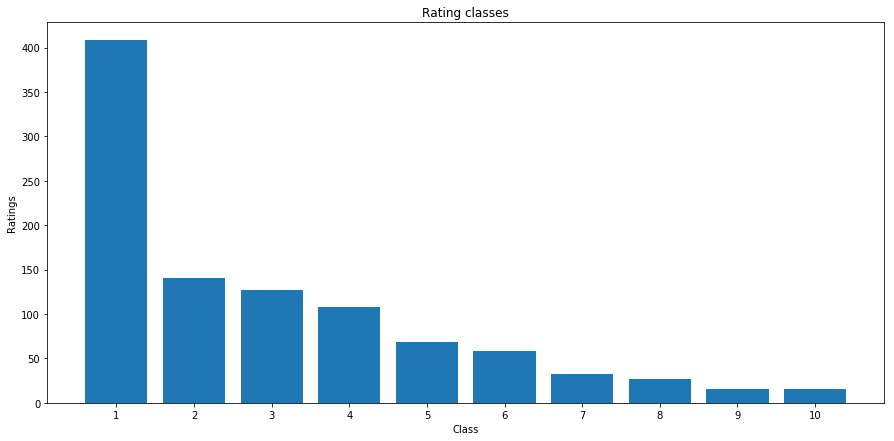

Total loss  Average variance  Total entropy  First class  Class width
0    0.010062          0.000327       1.829196    -4.159078     0.561406

In [17]:
portfolio.show_rating_hist()
portfolio.rating_summary()

In [18]:
np.sum(common_loss(portfolio._ratings))

67.344519543429143

## Relative loss

In [19]:
portfolio.optimize(optim_start[0],optim_start[1],rel_loss)['fun']
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1    198       -inf  -5.094945  0.000000  0.006090  0.002976   
1       2    148  -5.094945  -4.501600  0.006090  0.010970  0.008671   
2       3    121  -4.501600  -3.908254  0.010970  0.019680  0.015290   
3       4    145  -3.908254  -3.314909  0.019680  0.035063  0.026675   
4       5    130  -3.314909  -2.721564  0.035063  0.061713  0.047138   
5       6     85  -2.721564  -2.128219  0.061713  0.106384  0.079818   
6       7     60  -2.128219  -1.534873  0.106384  0.177282  0.137365   
7       8     44  -1.534873  -0.941528  0.177282  0.280592  0.214786   
8       9     36  -0.941528  -0.348183  0.280592  0.413823  0.347207   
9      10     33  -0.348183        inf  0.413823  1.000000  0.624692   

   assigned_pd  class_var          loss  
0     0.003045   0.000003  4.469862e+00  
1     0.008530   0.000002  2.441241e+00  
2     0.015325   0.000006  2.766064e-01  
3     0.027372   0.000019  3.691364e+00  
4     0.048388   0.000056  3.357442e+00  
5     0.084049   0.000140  4.278336e+00  
6     0.141833   0.000447  1.890107e+00  
7     0.228937   0.000802  2.719758e+00  
8     0.347207   0.001664  1.981761e-07  
9     0.706912   0.023402  3.838168e+00

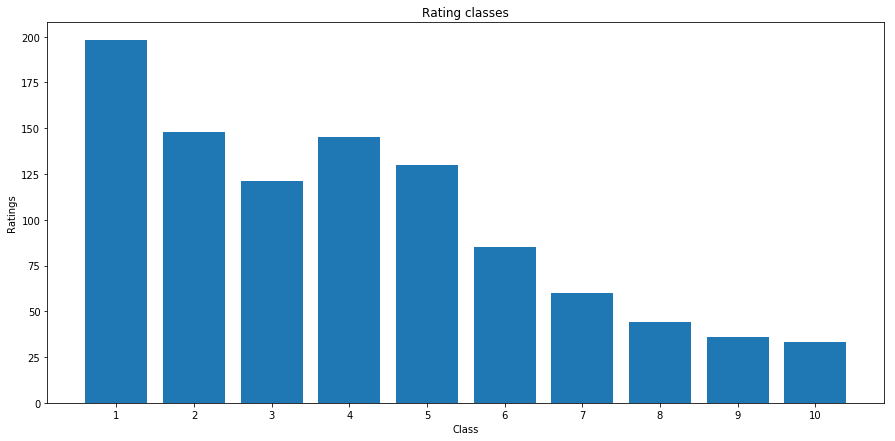

Total loss  Average variance  Total entropy  First class  Class width
0   26.962885          0.000918       2.152213    -5.094945     0.593345

In [20]:
portfolio.show_rating_hist()
portfolio.rating_summary()

In [21]:
np.sum(common_loss(portfolio._ratings))

26.962885271756768

## Entropy loss

In [102]:
portfolio.optimize(optim_start[0],optim_start[1],entropy_loss)['fun']
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1    100       -inf  -5.784441  0.000000  0.003066  0.001469   
1       2     72  -5.784441  -5.257916  0.003066  0.005179  0.004100   
2       3    104  -5.257916  -4.731390  0.005179  0.008737  0.007074   
3       4    124  -4.731390  -4.204865  0.008737  0.014703  0.011190   
4       5    120  -4.204865  -3.678339  0.014703  0.024642  0.019427   
5       6    126  -3.678339  -3.151814  0.024642  0.041020  0.031698   
6       7    107  -3.151814  -2.625288  0.041020  0.067529  0.051717   
7       8     77  -2.625288  -2.098763  0.067529  0.109217  0.083152   
8       9     54  -2.098763  -1.572237  0.109217  0.171898  0.136807   
9      10    116  -1.572237        inf  0.171898  1.000000  0.371511   

   assigned_pd   class_var      loss  
0     0.001533  0.00000088 -0.100000  
1     0.004122  0.00000035 -0.082272  
2     0.006958  0.00000114 -0.102229  
3     0.011720  0.00000274 -0.112416  
4     0.019673  0.00000774 -0.110498  
5     0.032831  0.00002414 -0.113353  
6     0.054274  0.00005096 -0.103856  
7     0.088373  0.00013894 -0.085740  
8     0.140557  0.00036164 -0.068451  
9     0.585949  0.03619442 -0.108523

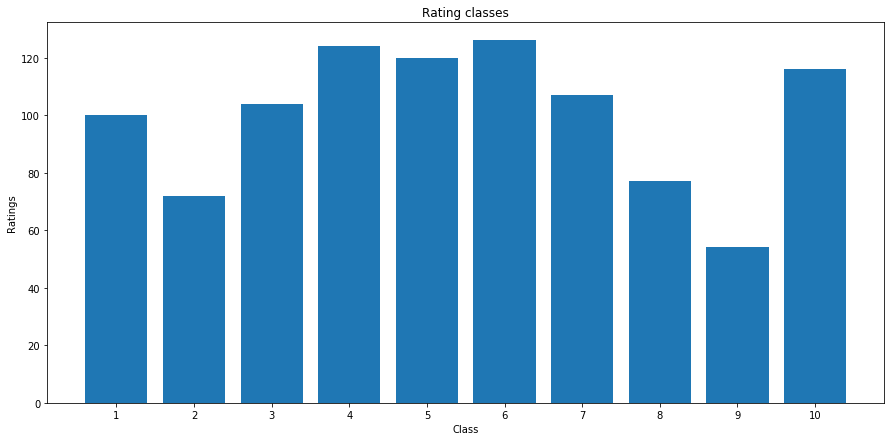

Total loss  Average variance  Total entropy  First class  Class width
0   -0.987338          0.004239       2.273429    -5.784441     0.526525

In [103]:
portfolio.show_rating_hist()
portfolio.rating_summary()

In [104]:
np.sum(common_loss(portfolio._ratings))

71.243123785754022

## Relative entropy loss

In [105]:
portfolio.optimize(optim_start[0],optim_start[1],rel_entropy_loss)['fun']
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1    144       -inf  -5.452359  0.000000  0.004268  0.002149   
1       2     83  -5.452359  -4.933219  0.004268  0.007152  0.005705   
2       3    133  -4.933219  -4.414078  0.007152  0.011961  0.009412   
3       4    112  -4.414078  -3.894938  0.011961  0.019939  0.015958   
4       5    123  -3.894938  -3.375797  0.019939  0.033060  0.025921   
5       6    123  -3.375797  -2.856657  0.033060  0.054338  0.043089   
6       7     88  -2.856657  -2.337516  0.054338  0.088063  0.070032   
7       8     55  -2.337516  -1.818376  0.088063  0.139629  0.111858   
8       9     54  -1.818376  -1.299235  0.139629  0.214294  0.178126   
9      10     85  -1.299235        inf  0.214294  1.000000  0.436068   

   assigned_pd   class_var      loss  
0     0.002134  0.00000170 -0.116159  
1     0.005710  0.00000071 -0.089131  
2     0.009556  0.00000164 -0.100441  
3     0.015950  0.00000555 -0.106037  
4     0.026500  0.00001243 -0.090411  
5     0.043699  0.00003930 -0.098136  
6     0.071201  0.00008731 -0.081205  
7     0.113846  0.00020498 -0.061450  
8     0.176961  0.00047693 -0.065516  
9     0.607147  0.03375584  0.054418

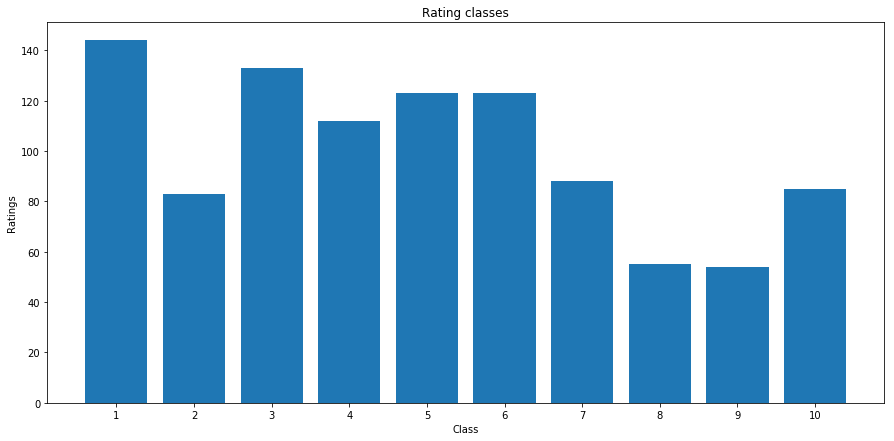

Total loss  Average variance  Total entropy  First class  Class width
0   -0.754069          0.002921       2.255213    -5.452359      0.51914

In [106]:
portfolio.show_rating_hist()
portfolio.rating_summary()

In [107]:
np.sum(common_loss(portfolio._ratings))

34.264436081540509

## Stdev loss

In [28]:
portfolio.optimize(optim_start[0],optim_start[1],stdev_loss)['fun']
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1    373       -inf  -4.346423  0.000000  0.012787  0.005889   
1       2    133  -4.346423  -3.737964  0.012787  0.023249  0.017789   
2       3    146  -3.737964  -3.129504  0.023249  0.041907  0.031352   
3       4    123  -3.129504  -2.521045  0.041907  0.074396  0.055546   
4       5     77  -2.521045  -1.912585  0.074396  0.128691  0.096794   
5       6     63  -1.912585  -1.304126  0.128691  0.213471  0.171726   
6       7     28  -1.304126  -0.695667  0.213471  0.332774  0.268910   
7       8     29  -0.695667  -0.087207  0.332774  0.478212  0.384281   
8       9     13  -0.087207   0.521252  0.478212  0.627441  0.528508   
9      10     15   0.521252        inf  0.627441  1.000000  0.768103   

   assigned_pd  class_var      loss  
0     0.006394   0.000013  1.331206  
1     0.018018   0.000009  0.399891  
2     0.032578   0.000031  0.808241  
3     0.058151   0.000088  1.150819  
4     0.101543   0.000262  1.246806  
5     0.171081   0.000656  1.613488  
6     0.273123   0.000938  0.857534  
7     0.405493   0.001286  1.039836  
8     0.552826   0.000984  0.407816  
9     0.813720   0.011198  1.587283

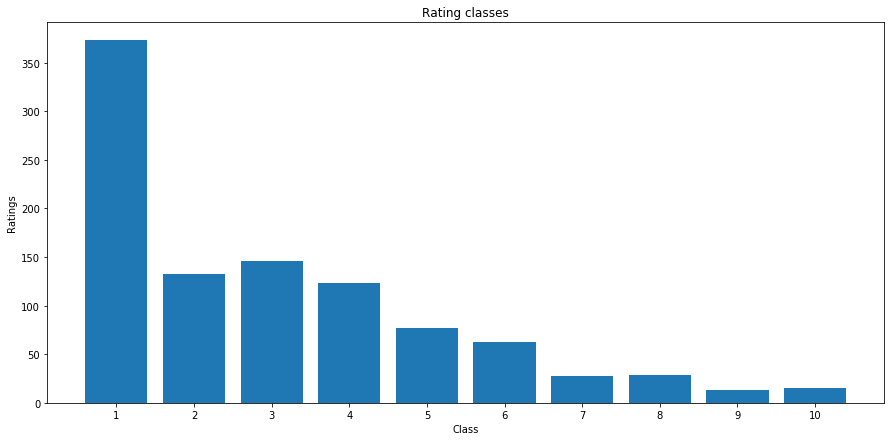

Total loss  Average variance  Total entropy  First class  Class width
0    10.44292          0.000327       1.868676    -4.346423     0.608459

In [29]:
portfolio.show_rating_hist()
portfolio.rating_summary()

In [30]:
np.sum(common_loss(portfolio._ratings))

49.332671093819044

## Relative stdev loss

In [31]:
portfolio.optimize(optim_start[0],optim_start[1],rel_stdev_loss)['fun']
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1    233       -inf  -4.903594  0.000000  0.007365  0.003548   
1       2    157  -4.903594  -4.275552  0.007365  0.013714  0.010169   
2       3    142  -4.275552  -3.647510  0.013714  0.025394  0.019533   
3       4    147  -3.647510  -3.019468  0.025394  0.046554  0.034921   
4       5    121  -3.019468  -2.391427  0.046554  0.083829  0.063013   
5       6     68  -2.391427  -1.763385  0.083829  0.146367  0.112847   
6       7     56  -1.763385  -1.135343  0.146367  0.243176  0.191085   
7       8     31  -1.135343  -0.507302  0.243176  0.375826  0.310851   
8       9     25  -0.507302   0.120740  0.375826  0.530148  0.440450   
9      10     20   0.120740        inf  0.530148  1.000000  0.716648   

   assigned_pd  class_var      loss  
0     0.003683   0.000005  9.008128  
1     0.010539   0.000003  5.800972  
2     0.019554   0.000011  0.625026  
3     0.035974   0.000039  5.223240  
4     0.065191   0.000122  5.379397  
5     0.115098   0.000325  2.554486  
6     0.194772   0.000613  2.446272  
7     0.309501   0.001240  1.226587  
8     0.452987   0.002593  1.965067  
9     0.765074   0.016418  3.828562

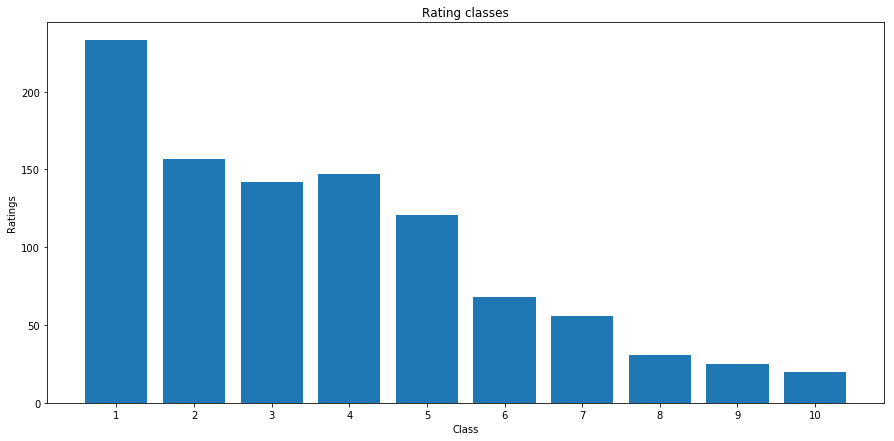

Total loss  Average variance  Total entropy  First class  Class width
0    38.05774          0.000512       2.067035    -4.903594     0.628042

In [32]:
portfolio.show_rating_hist()
portfolio.rating_summary()

In [33]:
np.sum(common_loss(portfolio._ratings))

27.017724347598964

## Squared loss suboptimal location

In [34]:
np.random.seed(seed=2017)
portfolio = Portfolio(size=1000,pdfunc = pd_normal, classes = 10)

In [35]:
bad_optim_start = [-4.6,0.1]

Squared error loss


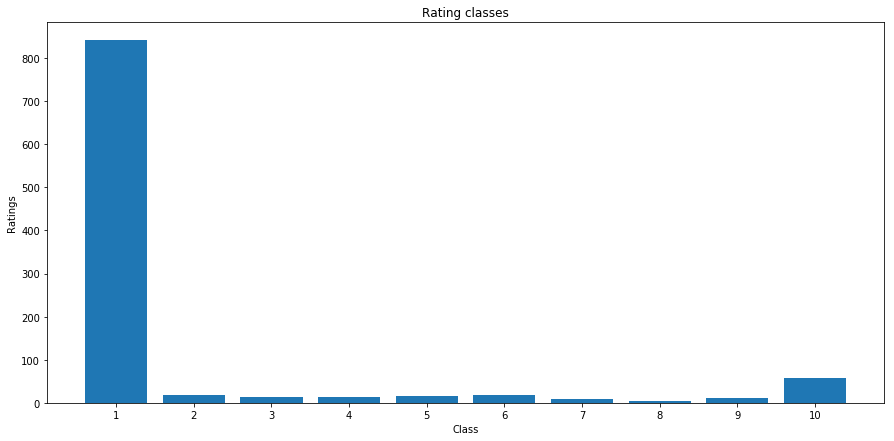

In [36]:
portfolio.optimize(bad_optim_start[0],bad_optim_start[1],squared_loss)['fun']
print("Squared error loss")
portfolio.show_rating_hist()

Standard error loss


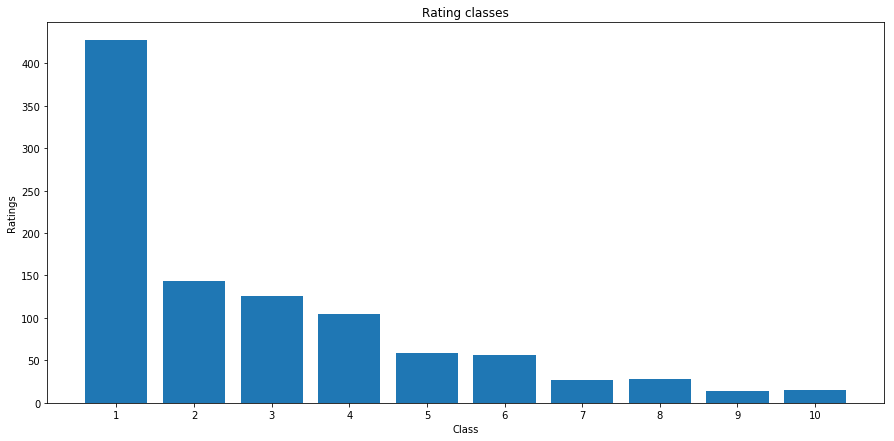

In [37]:
portfolio.optimize(bad_optim_start[0],bad_optim_start[1],stdev_loss)['fun']
print("Standard error loss")
portfolio.show_rating_hist()

## 15 classes

In [38]:
np.random.seed(seed=2017)
portfolio = Portfolio(size=1000,pdfunc = pd_normal, classes = 15)

Squared loss


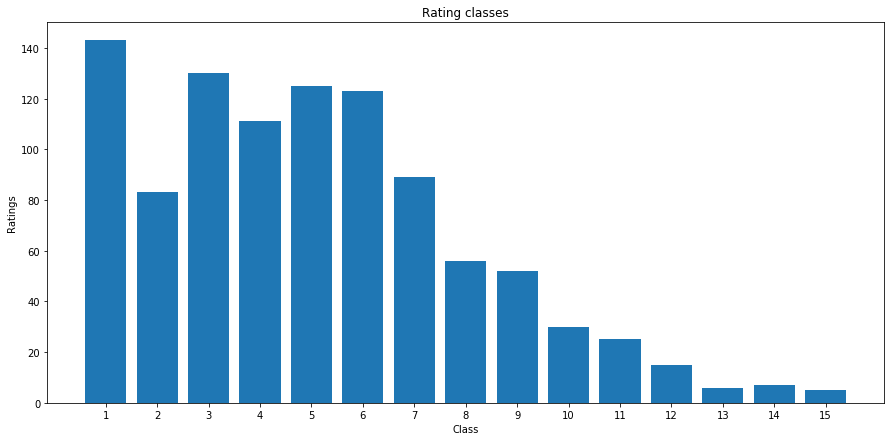

Relative loss


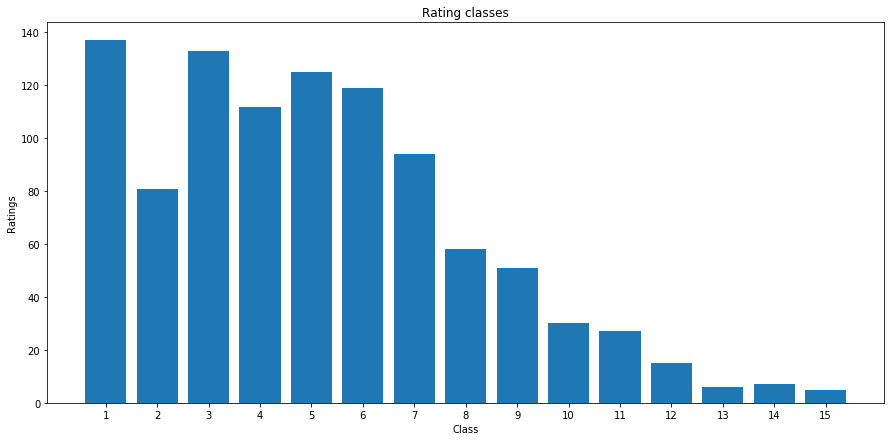

Entropy loss


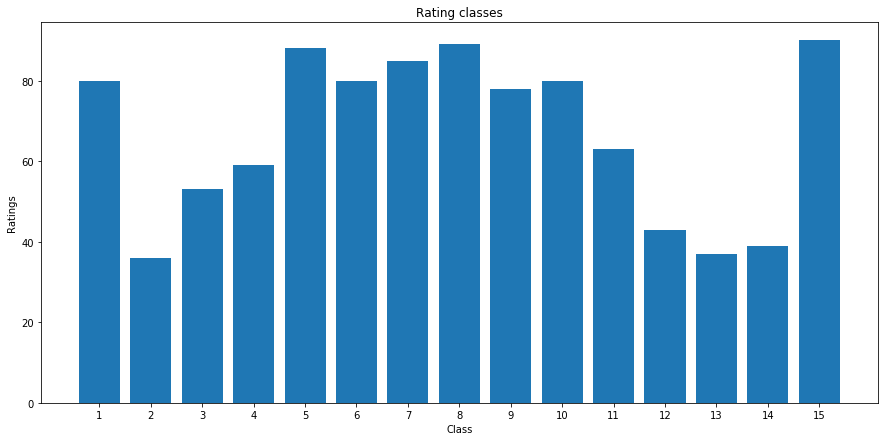

Relative entropy loss


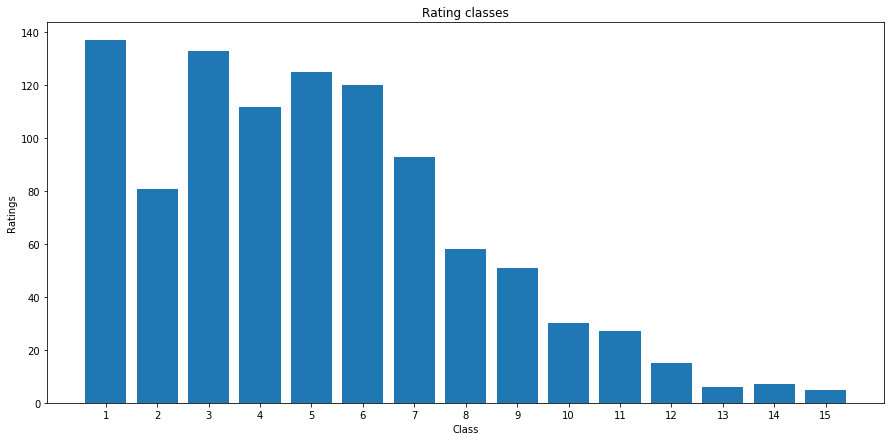

Standard deviation loss


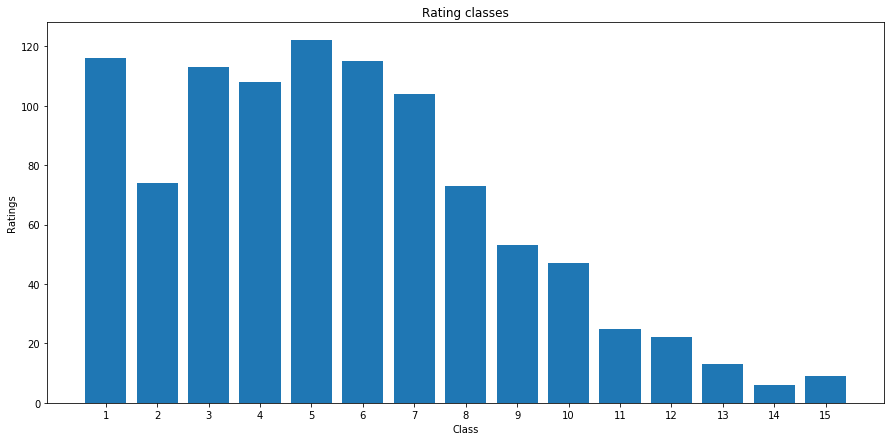

Relative standard deviation loss


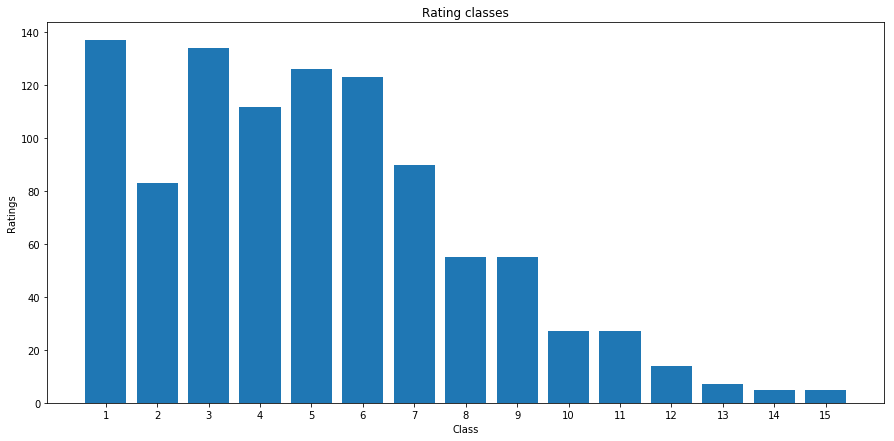

Loss function  Total common loss  Average variance  \
0                      Squared loss          12.346126          0.000162   
1                     Relative loss          11.249869          0.000167   
2                      Entropy loss          43.220034          0.003131   
3             Relative entropy loss          10.808188          0.000167   
4           Standard deviation loss          28.294388          0.000186   
5  Relative standard deviation loss           8.669837          0.000160   

   Total entropy  First class  Class width  
0       2.394409    -5.466646     0.519166  
1       2.399462    -5.499225     0.521616  
2       2.660904    -5.995620     0.356756  
3       2.399217    -5.499247     0.521638  
4       2.466268    -5.646694     0.502130  
5       2.390474    -5.494371     0.524770

In [39]:
optims15 = portfolio.optimize_list(params = optim_start, methods = methods, common_loss = common_loss)
optims15

## Comparison of rating metrics

In [23]:
iterations = 100000
rating_metrics = [
            {"scorename": "AR", "scorefunc": AR_score, "show_graph": True},
            {"scorename": "ROC", "scorefunc": ROC_score, "show_graph": False},
            {"scorename": "Cross entropy", "scorefunc": Cross_entropy_score, "show_graph": False},
            {"scorename": "Brier score", "scorefunc": Brier_score, "show_graph": False}
          ]

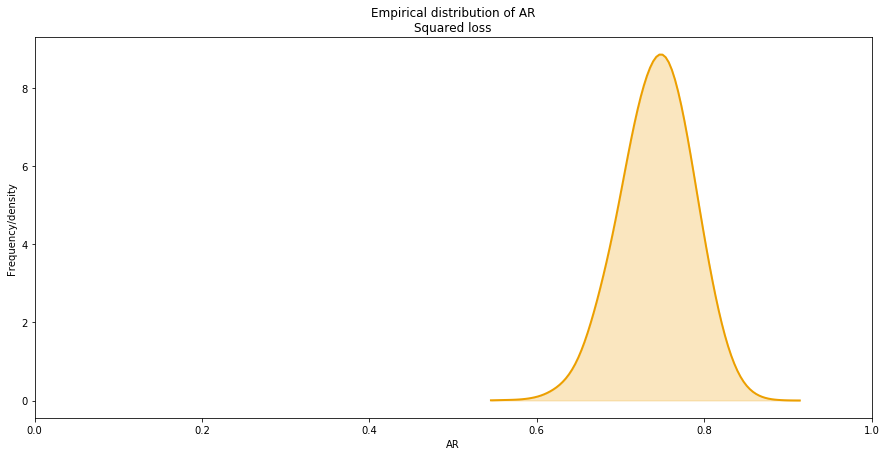

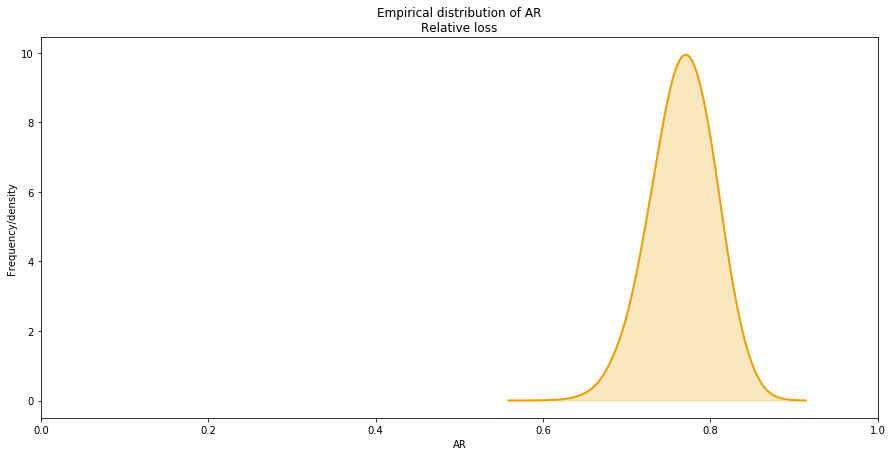

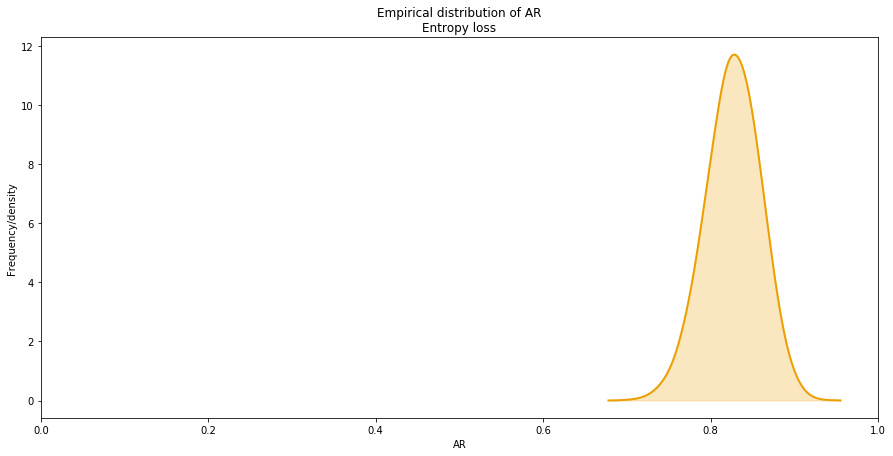

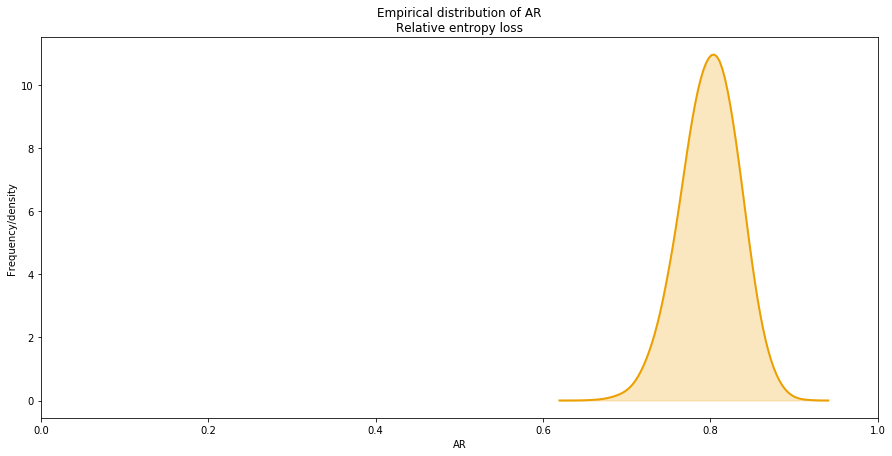

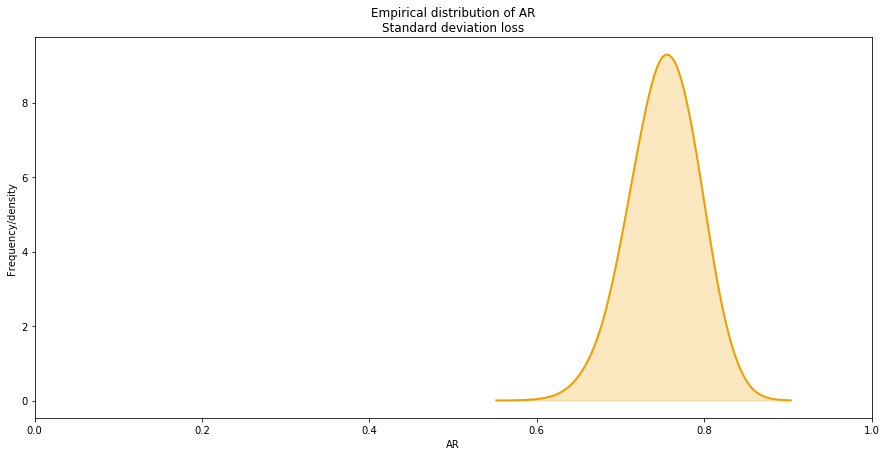

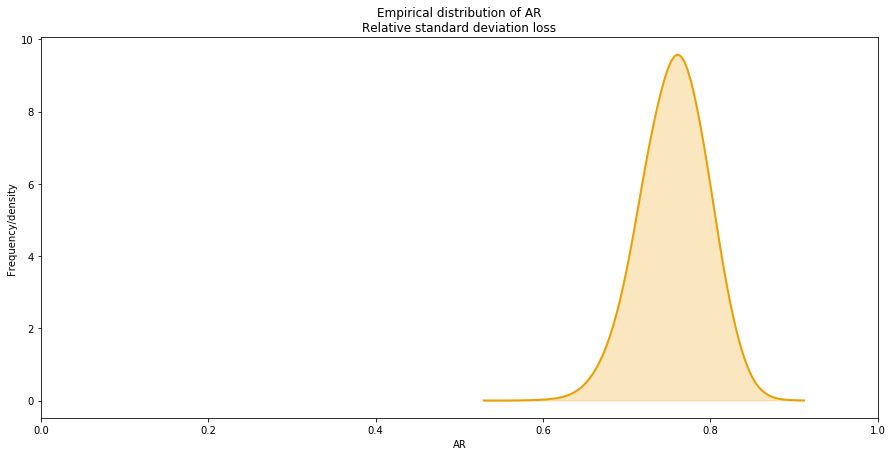

In [50]:
Scores = {}
for method in methods:        
    np.random.seed(seed=2017)
    portfolio = Portfolio(size=1000 ,pdfunc = pd_normal, classes = 10)
    
    params = optims.loc[optims['Loss function'] ==  method['title'],['First class', 'Class width']]
    portfolio.update_ratings(params.iloc[0,0],params.iloc[0,1], rel_loss)
    graph, summary = portfolio.simulate(iterations=iterations, subtitle=method['title'], rating_metrics=rating_metrics)
    Scores[method['title']] = {'graph': graph, 'summary': summary}

In [27]:
def compare(Scores, metric="AR"):
    score_compare = DataFrame(np.zeros(shape=(Scores[methods[0]['title']]['summary'][metric].shape[0],len(methods))))
    score_compare.columns = [method['title'] for method in methods]
    score_compare.index = Scores[methods[0]['title']]['summary'][metric].index
    for method in methods:
        score_compare[method['title']] = Scores[method['title']]['summary'][metric]
    
    return score_compare

def compare_graphs(Scores, graphs=[], metric="AR"):
    if graphs is None or len(graphs) != 2:
        raise Exception("Expecting graphs to be a list with two string entries")
        
    sc1, sc2 = Scores[graphs[0]]['graph'].copy(), Scores[graphs[1]]['graph'].copy()
    sc1["Score"] = sc1[metric]
    sc2["Score"] = sc2[metric]
    portfolio.score_graph_compare(sc1, sc2, label1=graphs[0], label2=graphs[1])

In [52]:
print("Accuracy ratio")
compare(Scores, "AR")

Accuracy ratio


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        0.742959       0.766815       0.826851               0.799386   
std         0.043707       0.038992       0.033007               0.035035   
min         0.545267       0.558648       0.678029               0.619610   
2.5%        0.653981       0.686057       0.759413               0.727336   
5%          0.668692       0.700167       0.770881               0.739750   
9.5%        0.684274       0.714757       0.782894               0.752569   
25%         0.714323       0.741481       0.805122               0.776375   
50%         0.744598       0.768246       0.827733               0.800628   
75%         0.773355       0.793913       0.849745               0.823830   
97.5%       0.824107       0.839241       0.888415               0.864453   
max         0.914206       0.913853       0.955254               0.940768   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  0.751975                          0.756617  
std                   0.041620                          0.040531  
min                   0.551638                          0.529233  
2.5%                  0.666060                          0.673455  
5%                    0.681242                          0.687722  
9.5%                  0.696461                          0.702699  
25%                   0.724663                          0.729859  
50%                   0.753355                          0.758070  
75%                   0.780907                          0.784731  
97.5%                 0.829224                          0.831994  
max                   0.903369                          0.911832

In [53]:
print("ROC")
compare(Scores, "ROC")

ROC


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        0.870330       0.882094       0.904843               0.897963   
std         0.021787       0.019478       0.015592               0.017334   
min         0.771628       0.778875       0.832249               0.809596   
2.5%        0.825962       0.841848       0.872497               0.862148   
5%          0.833366       0.848851       0.878168               0.868404   
9.5%        0.841087       0.856052       0.883949               0.874735   
25%         0.856052       0.869409       0.894715               0.886591   
50%         0.871134       0.882775       0.905422               0.898667   
75%         0.885468       0.895617       0.915745               0.910098   
97.5%       0.910824       0.918328       0.933589               0.929953   
max         0.955395       0.956926       0.959437               0.963295   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  0.875123                          0.877352  
std                   0.020748                          0.020212  
min                   0.775452                          0.764412  
2.5%                  0.832302                          0.835897  
5%                    0.839866                          0.843016  
9.5%                  0.847446                          0.850485  
25%                   0.861500                          0.864023  
50%                   0.875817                          0.878080  
75%                   0.889550                          0.891396  
97.5%                 0.913575                          0.914946  
max                   0.951685                          0.955350

In [54]:
print("Cross entropy")
compare(Scores, "Cross entropy")

Cross entropy


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        2.133803       1.944442       1.896429               1.924206   
std         0.031847       0.075995       0.161466               0.140755   
min         2.009293       1.640613       1.047521               1.282484   
2.5%        2.074053       1.802792       1.588374               1.653567   
5%          2.083059       1.823383       1.636375               1.696000   
9.5%        2.092666       1.846777       1.687978               1.742126   
25%         2.111871       1.892248       1.787602               1.828935   
50%         2.132950       1.942146       1.892956               1.922525   
75%         2.154689       1.993849       2.002549               2.016342   
97.5%       2.198490       2.101020       2.224880               2.206277   
max         2.287934       2.369208       2.717279               2.745481   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  2.099613                          2.002552  
std                   0.038763                          0.055988  
min                   1.954857                          1.809802  
2.5%                  2.027134                          1.899923  
5%                    2.038174                          1.915005  
9.5%                  2.049724                          1.930938  
25%                   2.072974                          1.963381  
50%                   2.098390                          2.000073  
75%                   2.125074                          2.039026  
97.5%                 2.179010                          2.118637  
max                   2.288714                          2.278820

In [55]:
print("Brier score")
compare(Scores, "Brier score")

Brier score


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        0.049978       0.050136       0.055293               0.051614   
std         0.004935       0.004925       0.004582               0.004759   
min         0.029625       0.028014       0.038007               0.031123   
2.5%        0.040657       0.040791       0.046684               0.042625   
5%          0.042090       0.042228       0.047974               0.043995   
9.5%        0.043575       0.043787       0.049386               0.045462   
25%         0.046580       0.046746       0.052135               0.048335   
50%         0.049865       0.050033       0.055180               0.051490   
75%         0.053248       0.053406       0.058315               0.054792   
97.5%       0.059959       0.060042       0.064605               0.061228   
max         0.073817       0.071973       0.077270               0.075802   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  0.050060                          0.049760  
std                   0.004934                          0.004926  
min                   0.030685                          0.029635  
2.5%                  0.040713                          0.040441  
5%                    0.042135                          0.041851  
9.5%                  0.043674                          0.043395  
25%                   0.046668                          0.046384  
50%                   0.049952                          0.049651  
75%                   0.053335                          0.053025  
97.5%                 0.060039                          0.059765  
max                   0.072129                          0.073048

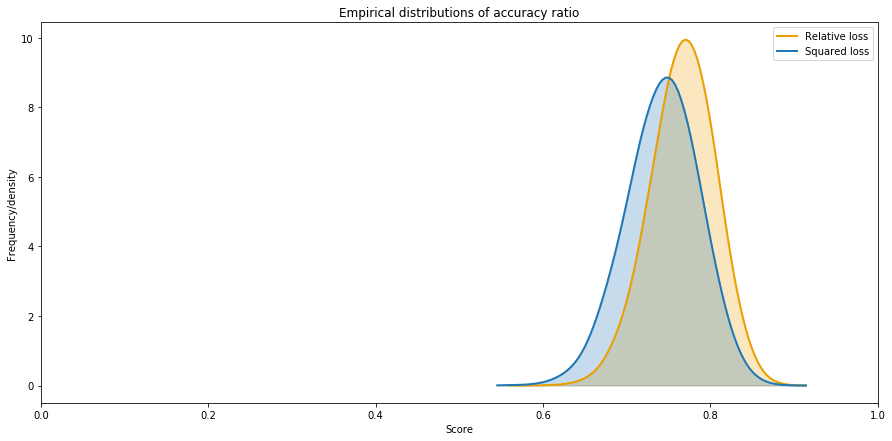

In [56]:
compare_graphs(Scores,['Relative loss', 'Squared loss'],"AR")

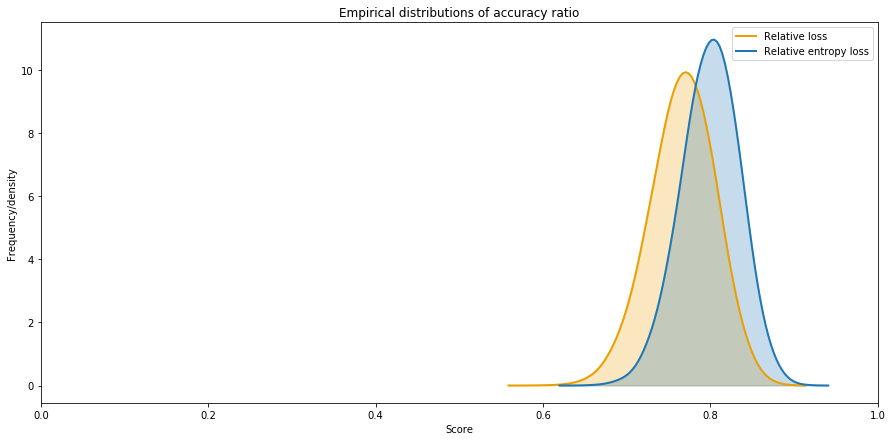

In [57]:
compare_graphs(Scores,['Relative loss', 'Relative entropy loss'],"AR")

# Case study 2 - subprime portfolio

In [10]:
np.random.seed(seed=20171)
portfolio = Portfolio(size=1000,pdfunc = pd_subprime)
portfolio._portfolio.head(10)

PD  Score_logit
0  0.983954     4.116135
1  0.907701     2.285884
2  0.923153     2.485977
3  0.730676     0.998054
4  0.994918     5.276877
5  0.846039     1.703865
6  0.929745     2.582786
7  0.998086     6.256547
8  0.929738     2.582667
9  0.962126     3.234880

In [11]:
portfolio._portfolio.describe()

PD  Score_logit
count  1000.000000  1000.000000
mean      0.849911     2.564084
std       0.190534     1.845926
min       0.014456    -4.222090
25%       0.809247     1.445127
50%       0.925458     2.518950
75%       0.976256     3.716377
max       0.999997    12.579226

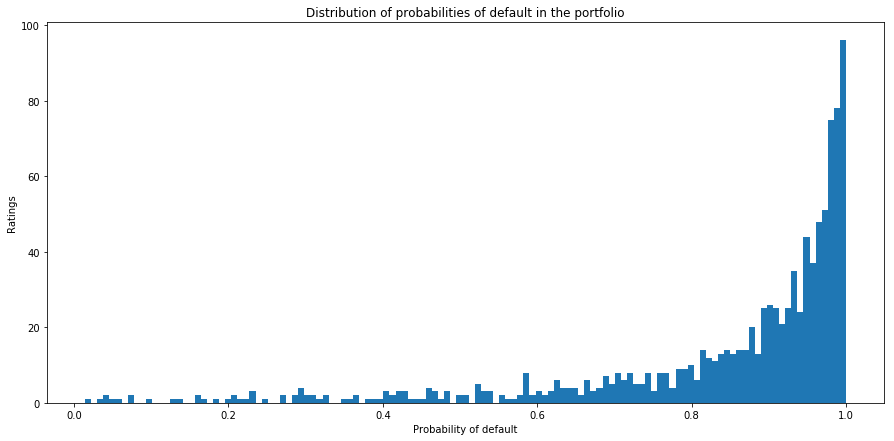

In [12]:
portfolio.show_pd_hist()

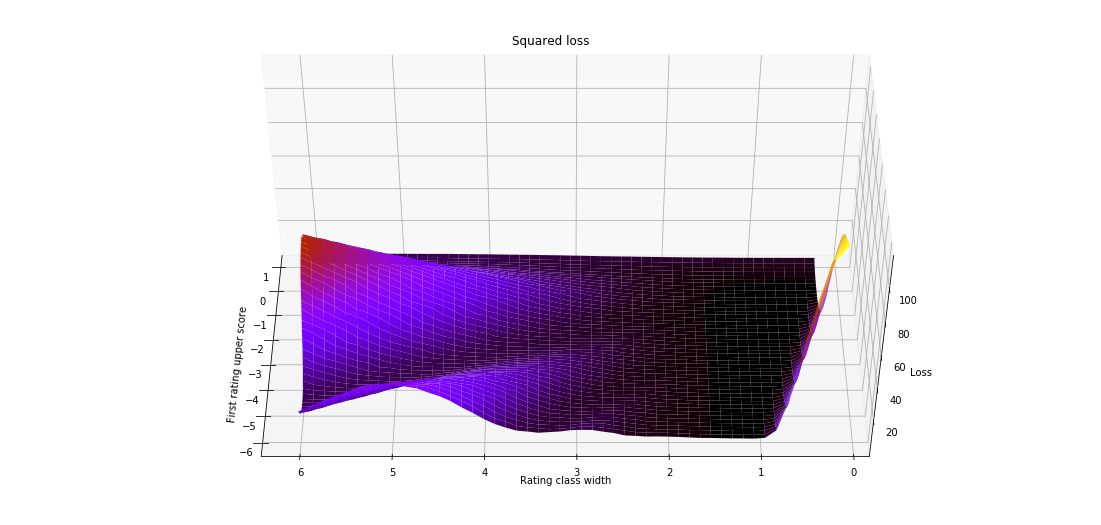

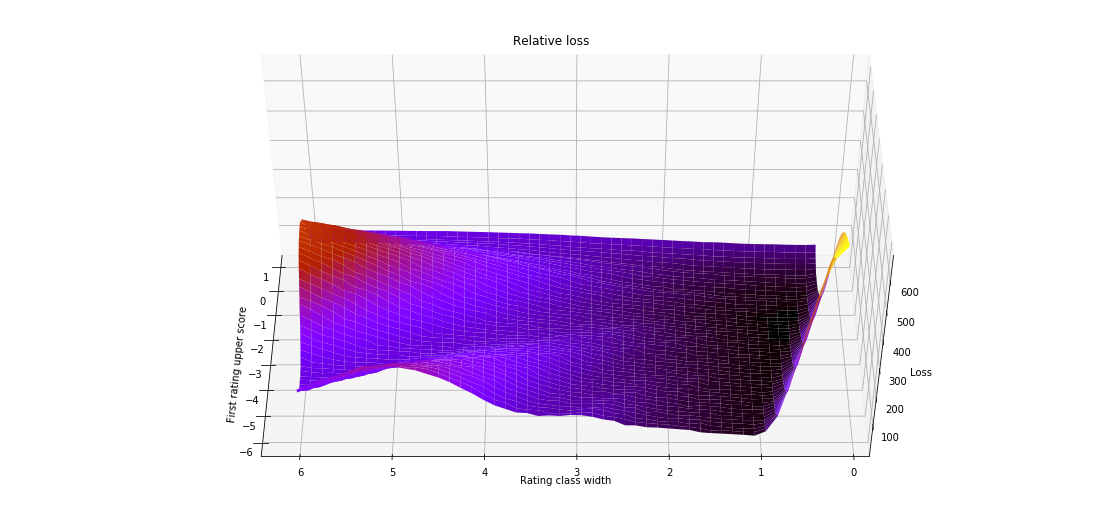

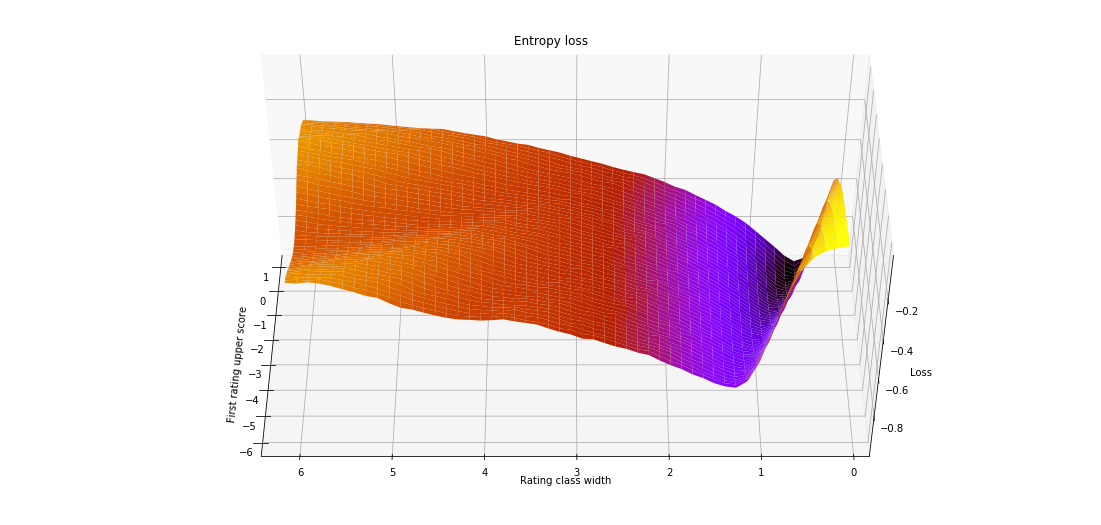

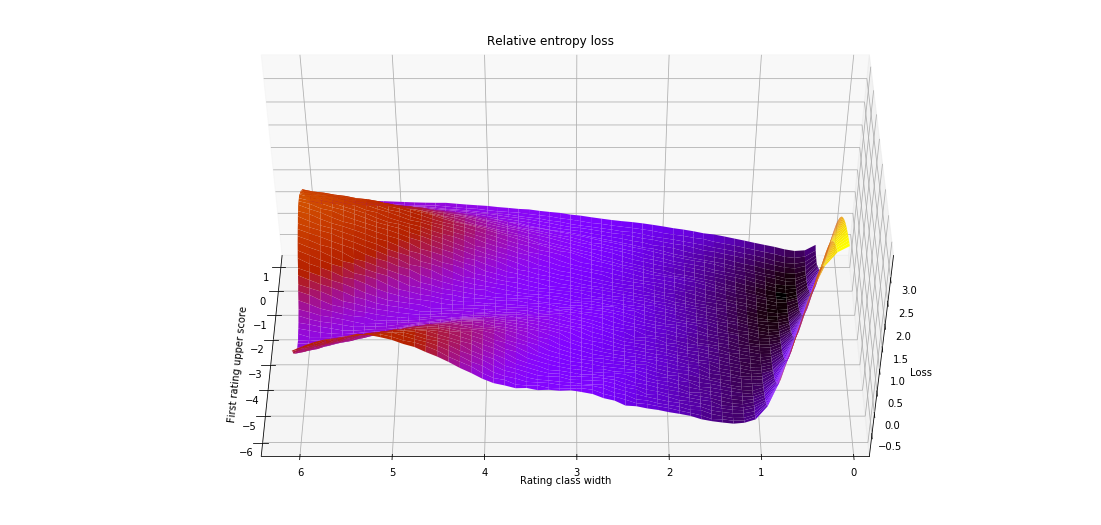

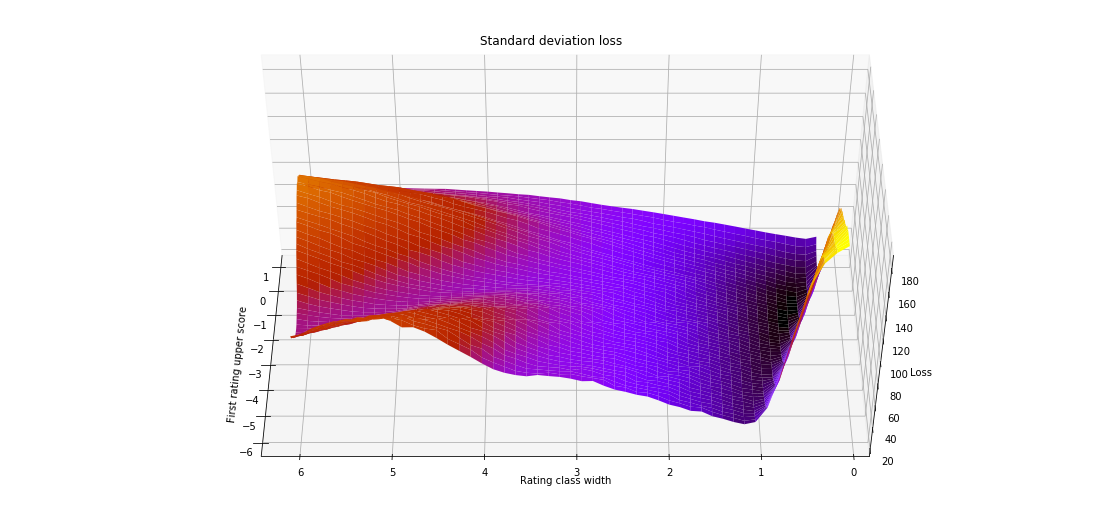

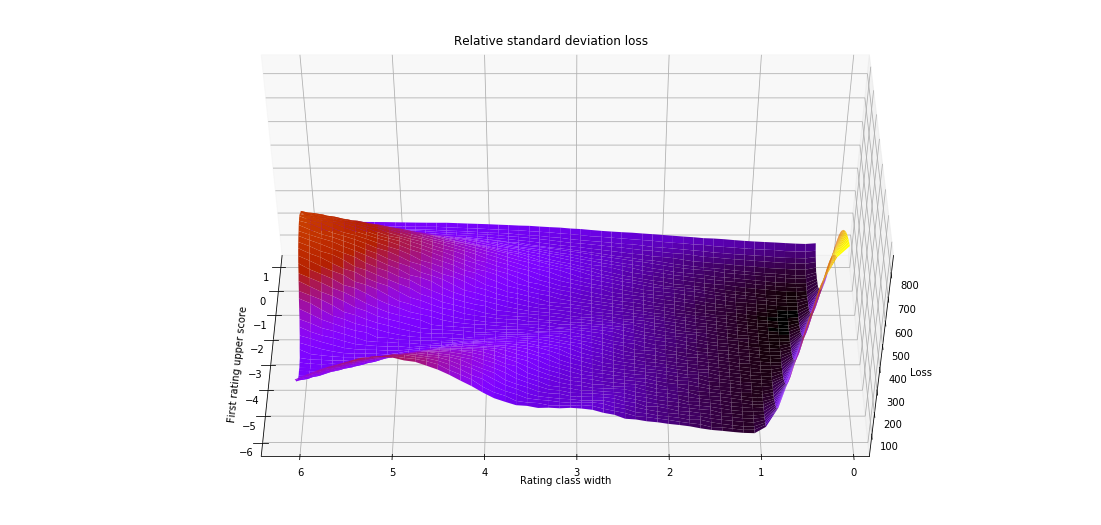

In [154]:
ranges = [[-6,1],[0.25,6]]
points = 50

for method in methods:    
    portfolio.show_parameter_space(ranges, points, method['lossfunc'], name=method['name'], title=method['title'], save=False);

In [13]:
np.random.seed(seed=20171)
portfolio = Portfolio(size=1000, pdfunc = pd_subprime, classes = 10)

Squared loss


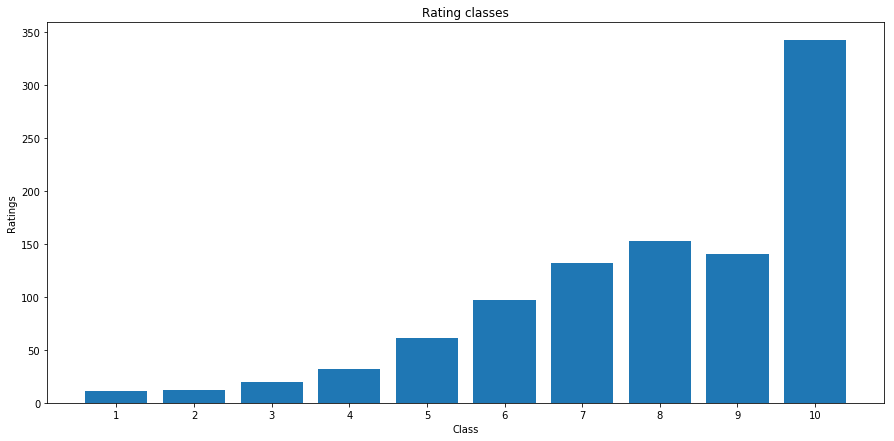

Relative loss


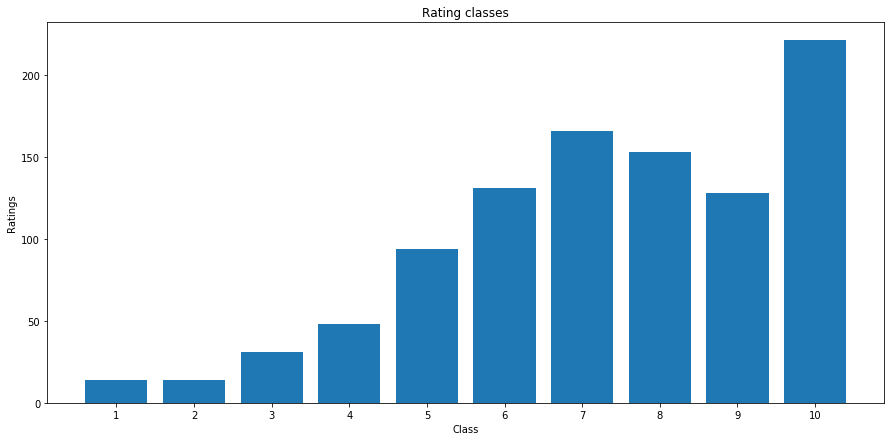

Entropy loss


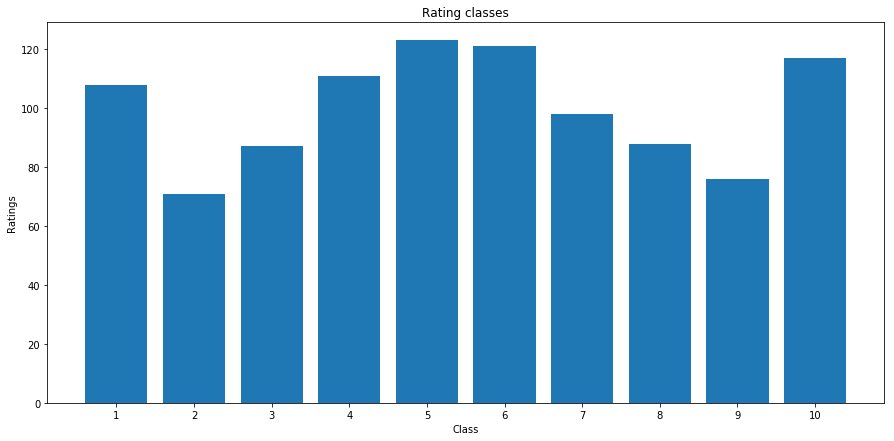

Relative entropy loss


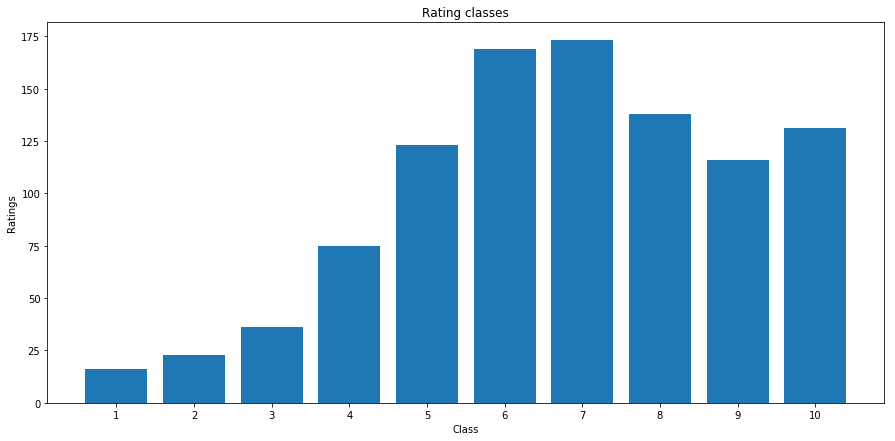

Standard deviation loss


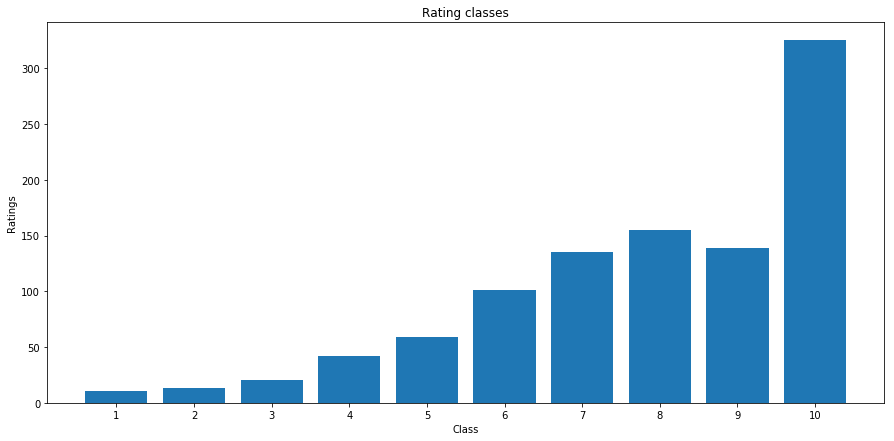

Relative standard deviation loss


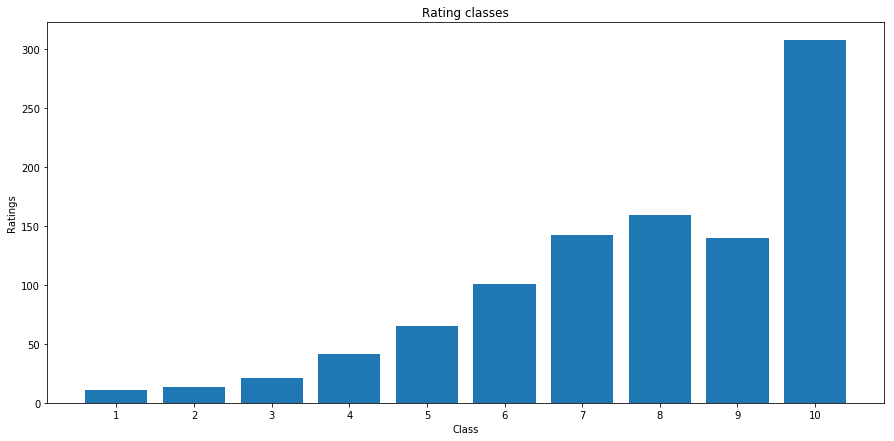

Loss function  Total common loss  Average variance  \
0                      Squared loss           5.011934          0.000483   
1                     Relative loss           3.342766          0.000597   
2                      Entropy loss          30.686191          0.003169   
3             Relative entropy loss           3.903419          0.000682   
4           Standard deviation loss           5.234462          0.000485   
5  Relative standard deviation loss           4.401519          0.000502   

   Total entropy  First class  Class width  
0       1.884709    -1.795603     0.626596  
1       2.043569    -1.564259     0.678827  
2       2.286311     0.483341     0.509822  
3       2.118060    -1.366645     0.728516  
4       1.914857    -1.706924     0.624668  
5       1.934725    -1.731771     0.639179

In [14]:
optim_start = [-1.8, 0.6]
common_loss = rel_loss

optims_sub = portfolio.optimize_list(params = optim_start, methods = methods, common_loss = common_loss)
optims_sub

### Relative loss

In [15]:
portfolio.optimize(optim_start[0],optim_start[1],rel_loss)['fun']
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1     14       -inf  -1.564259  0.000000  0.173036  0.088656   
1       2     14  -1.564259  -0.885432  0.173036  0.292053  0.234538   
2       3     31  -0.885432  -0.206605  0.292053  0.448532  0.369237   
3       4     48  -0.206605   0.472222  0.448532  0.615910  0.536986   
4       5     94   0.472222   1.151049  0.615910  0.759703  0.692761   
5       6    131   1.151049   1.829876  0.759703  0.861747  0.815749   
6       7    166   1.829876   2.508703  0.861747  0.924750  0.895741   
7       8    153   2.508703   3.187531  0.924750  0.960362  0.943603   
8       9    128   3.187531   3.866358  0.960362  0.979495  0.970635   
9      10    221   3.866358        inf  0.979495  1.000000  0.990389   

   assigned_pd   class_var      loss  
0     0.086518  0.00254740  0.345910  
1     0.232545  0.00093549  0.119991  
2     0.370293  0.00266455  0.088373  
3     0.532221  0.00246710  0.429772  
4     0.687806  0.00169375  0.677221  
5     0.810725  0.00082391  0.811760  
6     0.893248  0.00031219  0.463191  
7     0.942556  0.00010135  0.169975  
8     0.969929  0.00003399  0.093234  
9     0.989747  0.00003596  0.143340

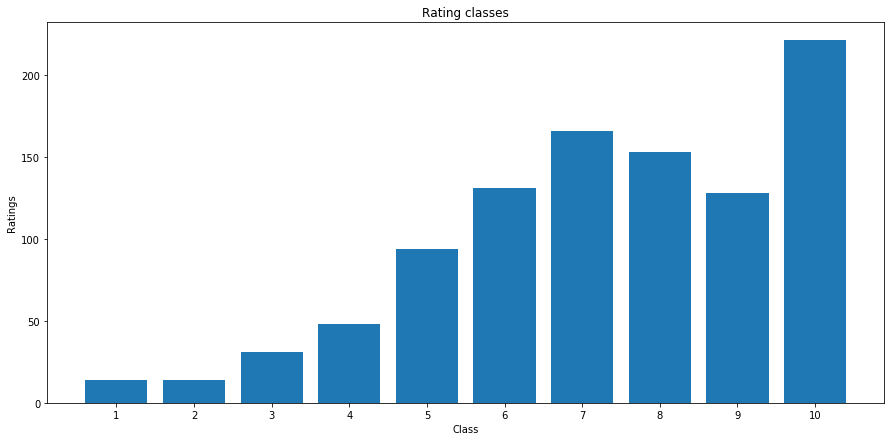

Total loss  Average variance  Total entropy  First class  Class width
0    3.342766          0.000597       2.043569    -1.564259     0.678827

In [16]:
portfolio.show_rating_hist()
portfolio.rating_summary()

### Entropy loss

In [17]:
portfolio.optimize(optim_start[0],optim_start[1],entropy_loss)['fun']
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1    108       -inf   0.483341  0.000000  0.618537  0.392250   
1       2     71   0.483341   0.993164  0.618537  0.729712  0.678022   
2       3     87   0.993164   1.502986  0.729712  0.818019  0.779349   
3       4    111   1.502986   2.012809  0.818019  0.882135  0.852817   
4       5    123   2.012809   2.522631  0.882135  0.925713  0.904904   
5       6    121   2.522631   3.032454  0.925713  0.954019  0.940621   
6       7     98   3.032454   3.542276  0.954019  0.971867  0.963111   
7       8     88   3.542276   4.052099  0.971867  0.982911  0.977596   
8       9     76   4.052099   4.561921  0.982911  0.989666  0.986316   
9      10    117   4.561921        inf  0.989666  1.000000  0.995302   

   assigned_pd   class_var      loss  
0     0.309268  0.02741344 -0.104390  
1     0.674124  0.00111388 -0.081561  
2     0.773866  0.00069255 -0.092262  
3     0.850077  0.00035441 -0.105969  
4     0.903924  0.00013194 -0.111942  
5     0.939866  0.00006889 -0.110983  
6     0.962943  0.00002590 -0.098860  
7     0.977389  0.00000881 -0.092886  
8     0.986289  0.00000441 -0.085058  
9     0.994833  0.00000846 -0.109022

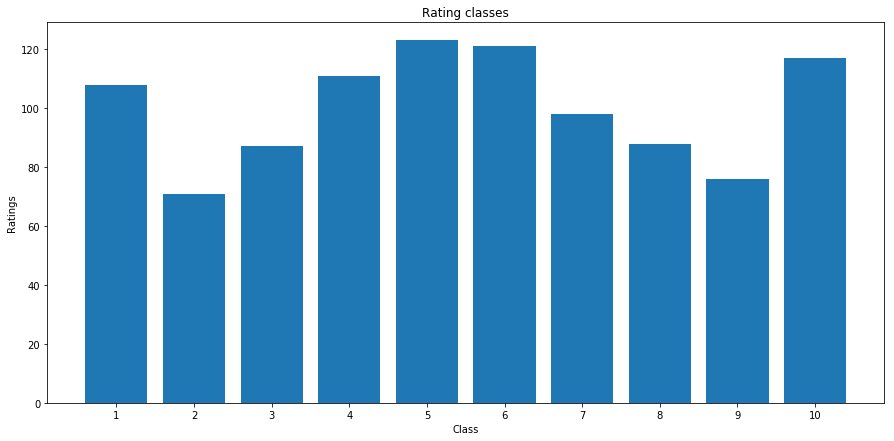

Total loss  Average variance  Total entropy  First class  Class width
0   -0.992932          0.003169       2.286311     0.483341     0.509822

In [18]:
portfolio.show_rating_hist()
portfolio.rating_summary()

### Relative entropy loss

In [19]:
portfolio.optimize(optim_start[0],optim_start[1],rel_entropy_loss)['fun']
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1     16       -inf  -1.366645  0.000000  0.203162  0.101513   
1       2     23  -1.366645  -0.638129  0.203162  0.345670  0.272933   
2       3     36  -0.638129   0.090387  0.345670  0.522581  0.436238   
3       4     75   0.090387   0.818903  0.522581  0.694004  0.617103   
4       5    123   0.818903   1.547420  0.694004  0.824541  0.765574   
5       6    169   1.547420   2.275936  0.824541  0.906864  0.870595   
6       7    173   2.275936   3.004452  0.906864  0.952775  0.931687   
7       8    138   3.004452   3.732968  0.952775  0.976637  0.965472   
8       9    116   3.732968   4.461484  0.976637  0.988587  0.982851   
9      10    131   4.461484        inf  0.988587  1.000000  0.994639   

   assigned_pd   class_var      loss  
0     0.101581  0.00339679 -0.028680  
1     0.274416  0.00150145 -0.036693  
2     0.434126  0.00189325 -0.050518  
3     0.608292  0.00258606 -0.074849  
4     0.759272  0.00152814 -0.102542  
5     0.865703  0.00059604 -0.121369  
6     0.929820  0.00018817 -0.128427  
7     0.964706  0.00004901 -0.117614  
8     0.982612  0.00001218 -0.108242  
9     0.994293  0.00001124 -0.115184

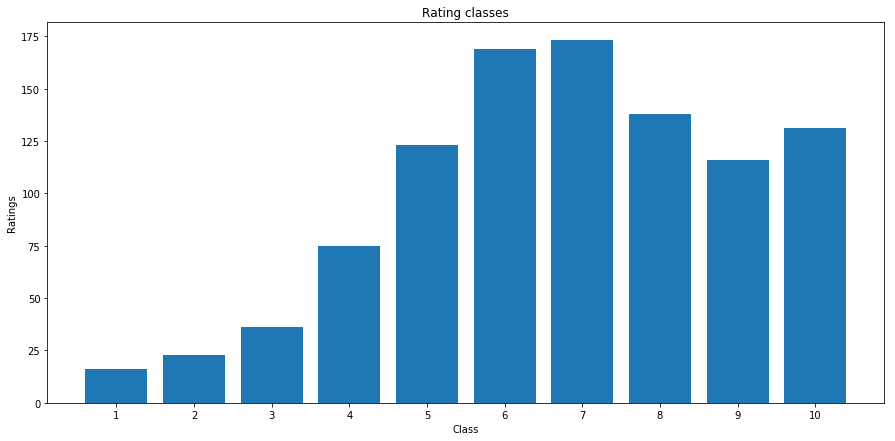

Total loss  Average variance  Total entropy  First class  Class width
0   -0.884119          0.000682        2.11806    -1.366645     0.728516

In [20]:
portfolio.show_rating_hist()
portfolio.rating_summary()

## Comparison of rating metrics

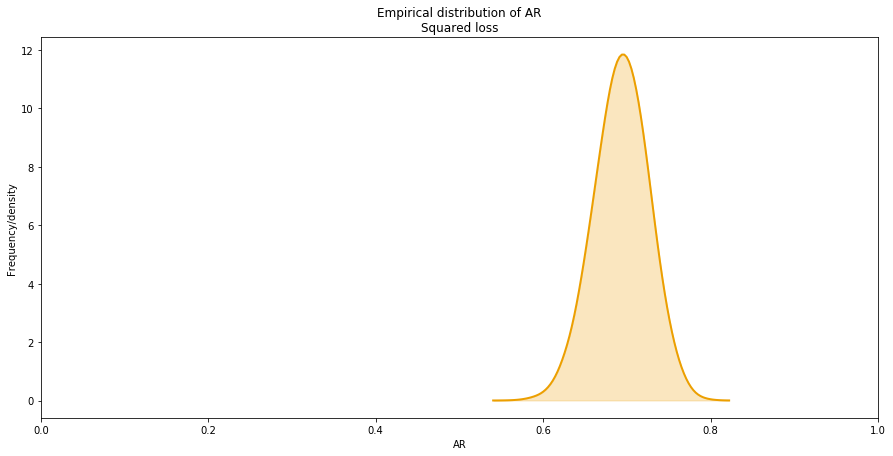

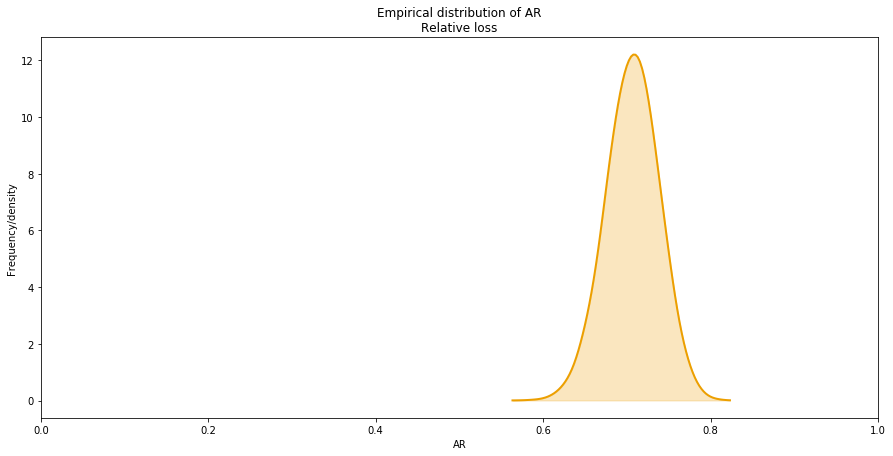

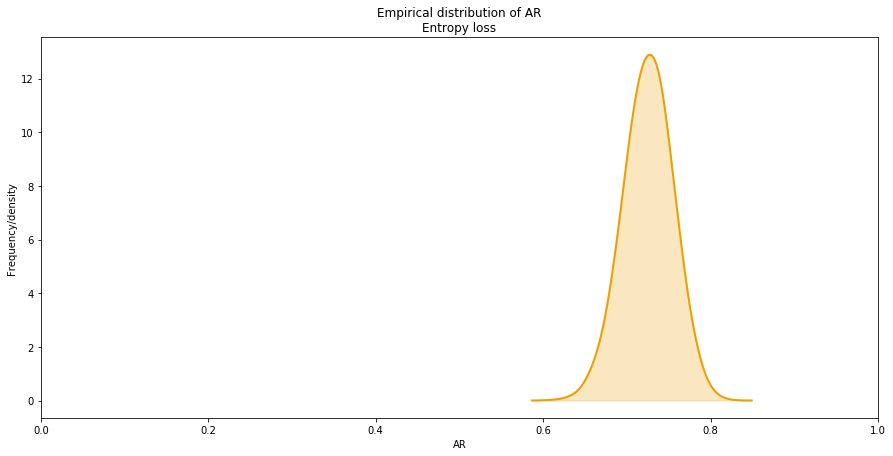

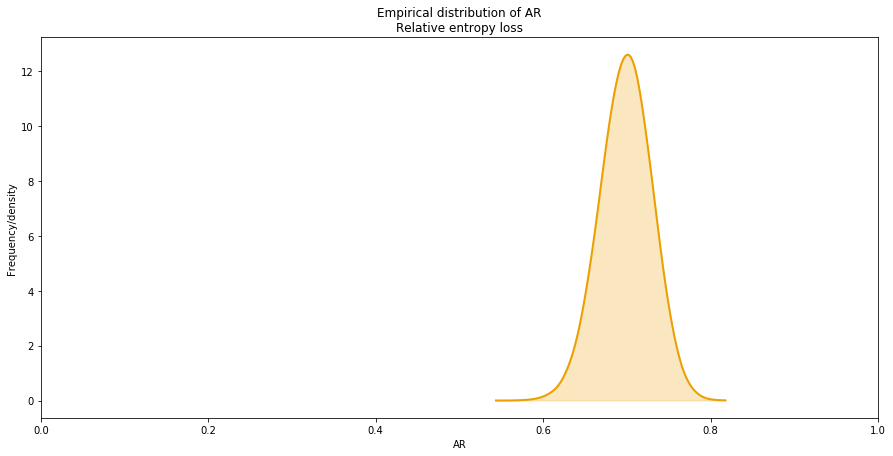

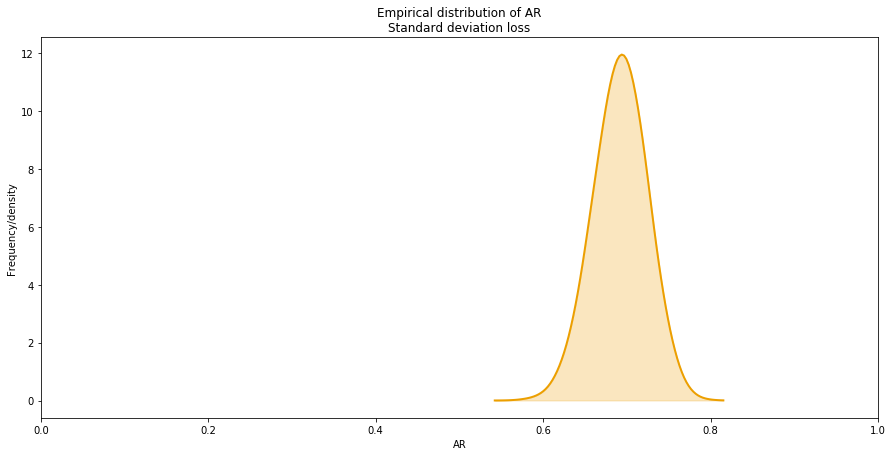

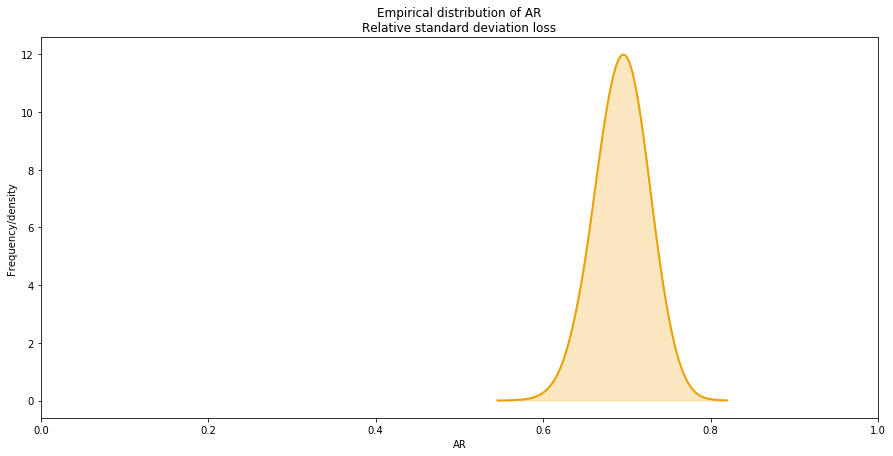

In [24]:
Scores = {}
for method in methods:        
    np.random.seed(seed=20171)
    portfolio = Portfolio(size=1000, pdfunc=pd_subprime, classes = 10)
    
    params = optims_sub.loc[optims_sub['Loss function'] ==  method['title'],['First class', 'Class width']]
    portfolio.update_ratings(params.iloc[0,0],params.iloc[0,1], rel_loss)
    graph, summary = portfolio.simulate(iterations=iterations, subtitle=method['title'], rating_metrics=rating_metrics)
    Scores[method['title']] = {'graph': graph, 'summary': summary}

In [28]:
print("Accuracy ratio")
compare(Scores, "AR")

Accuracy ratio


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        0.693464       0.706693       0.725353               0.698818   
std         0.032635       0.031609       0.029850               0.030752   
min         0.540279       0.563356       0.586460               0.543626   
2.5%        0.627409       0.643069       0.664760               0.636805   
5%          0.638586       0.653554       0.675393               0.647471   
9.5%        0.650113       0.664996       0.685999               0.658099   
25%         0.671877       0.685665       0.705538               0.678359   
50%         0.694255       0.707331       0.725957               0.699445   
75%         0.715931       0.728300       0.745781               0.719876   
97.5%       0.755317       0.767034       0.782040               0.757098   
max         0.822188       0.823188       0.849121               0.817862   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  0.692112                          0.693862  
std                   0.032460                          0.032261  
min                   0.542180                          0.545463  
2.5%                  0.626723                          0.628936  
5%                    0.637516                          0.639737  
9.5%                  0.648996                          0.651070  
25%                   0.670614                          0.672404  
50%                   0.692830                          0.694490  
75%                   0.714425                          0.715979  
97.5%                 0.753827                          0.755354  
max                   0.815285                          0.819605

In [29]:
print("ROC")
compare(Scores, "ROC")

ROC


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        0.843328       0.847546       0.860206               0.847404   
std         0.016229       0.015525       0.014728               0.015298   
min         0.770140       0.777206       0.792686               0.769489   
2.5%        0.810556       0.816269       0.830307               0.816582   
5%          0.816069       0.821430       0.835459               0.821866   
9.5%        0.821772       0.827047       0.840753               0.827195   
25%         0.832556       0.837217       0.850436               0.837253   
50%         0.843704       0.847852       0.860536               0.847722   
75%         0.854494       0.858184       0.870296               0.857869   
97.5%       0.874245       0.877159       0.888054               0.876449   
max         0.908981       0.905941       0.920290               0.906723   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  0.843965                          0.845431  
std                   0.016187                          0.016071  
min                   0.770873                          0.772103  
2.5%                  0.811398                          0.813122  
5%                    0.816807                          0.818454  
9.5%                  0.822520                          0.824128  
25%                   0.833218                          0.834732  
50%                   0.844321                          0.845736  
75%                   0.855068                          0.856435  
97.5%                 0.874785                          0.876089  
max                   0.905830                          0.909525

In [30]:
print("Cross entropy")
compare(Scores, "Cross entropy")

Cross entropy


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        1.685535       1.779236       2.156878               1.848849   
std         0.018921       0.015046       0.003701               0.012775   
min         1.601868       1.711684       2.139736               1.791264   
2.5%        1.649064       1.750323       2.149529               1.824284   
5%          1.654790       1.754820       2.150770               1.828150   
9.5%        1.660902       1.759695       2.152015               1.832230   
25%         1.672602       1.768939       2.154388               1.840173   
50%         1.685336       1.779033       2.156909               1.848669   
75%         1.698167       1.789231       2.159386               1.857342   
97.5%       1.723198       1.809293       2.164049               1.874402   
max         1.766157       1.847992       2.174512               1.904929   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  1.707563                          1.708456  
std                   0.018243                          0.017762  
min                   1.632187                          1.631811  
2.5%                  1.672358                          1.674075  
5%                    1.677763                          1.679503  
9.5%                  1.683732                          1.685239  
25%                   1.695176                          1.696467  
50%                   1.707374                          1.708250  
75%                   1.719757                          1.720319  
97.5%                 1.743946                          1.743964  
max                   1.795001                          1.796831

In [31]:
print("Brier score")
compare(Scores, "Brier score")

Brier score


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        0.093606       0.093132       0.092613               0.093570   
std         0.005886       0.005835       0.005918               0.005834   
min         0.070493       0.069390       0.068192               0.069150   
2.5%        0.082403       0.082005       0.081307               0.082478   
5%          0.084133       0.083736       0.083056               0.084176   
9.5%        0.085972       0.085554       0.084932               0.086015   
25%         0.089570       0.089132       0.088578               0.089576   
50%         0.093502       0.093021       0.092513               0.093446   
75%         0.097506       0.097029       0.096540               0.097425   
97.5%       0.105466       0.104861       0.104526               0.105312   
max         0.118631       0.117845       0.120806               0.119482   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  0.093528                          0.093054  
std                   0.005875                          0.005862  
min                   0.070822                          0.070229  
2.5%                  0.082313                          0.081879  
5%                    0.084063                          0.083567  
9.5%                  0.085901                          0.085450  
25%                   0.089519                          0.089047  
50%                   0.093426                          0.092961  
75%                   0.097417                          0.096967  
97.5%                 0.105364                          0.104880  
max                   0.119204                          0.121191

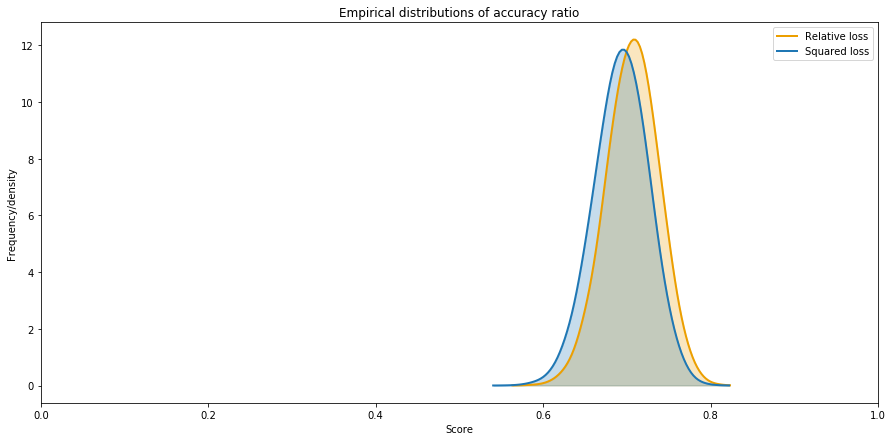

In [32]:
compare_graphs(Scores,['Relative loss', 'Squared loss'],"AR")

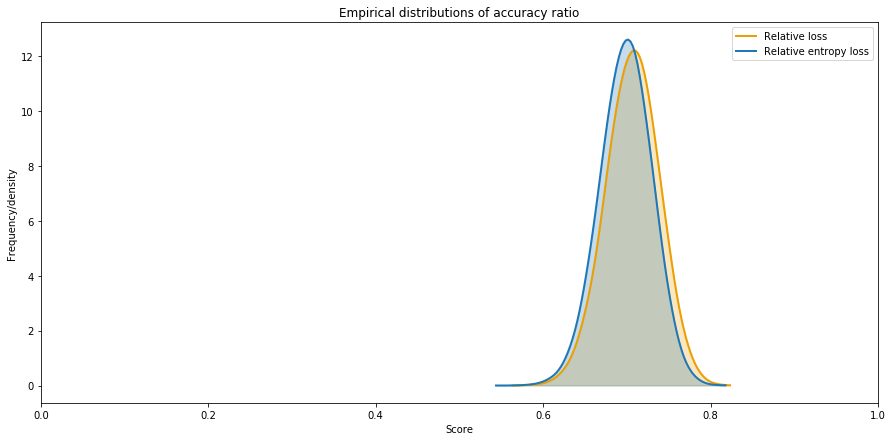

In [33]:
compare_graphs(Scores,['Relative loss', 'Relative entropy loss'],"AR")

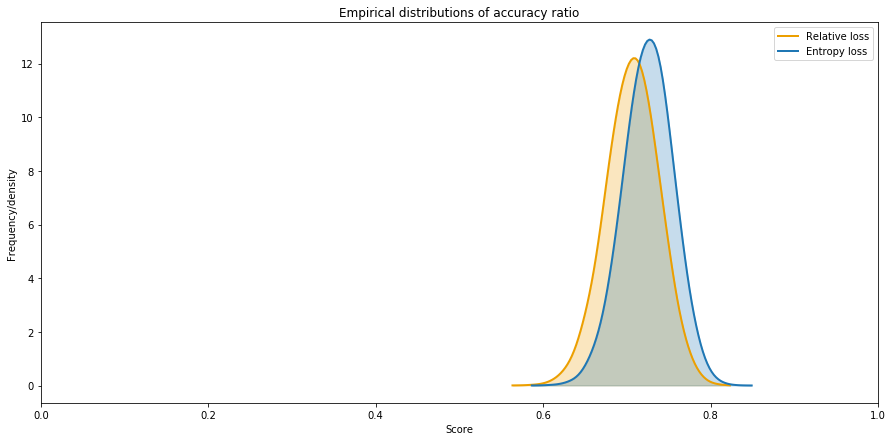

In [34]:
compare_graphs(Scores,['Relative loss', 'Entropy loss'],"AR")

# Case study 3 - bimodal portfolio

In [35]:
np.random.seed(seed=201711)
portfolio = Portfolio(size=1000,pdfunc = pd_bimodal)
portfolio._portfolio.head(10)

PD  Score_logit
0  0.709010     0.890580
1  0.786379     1.303236
2  0.604866     0.425784
3  0.838523     1.647282
4  0.112718    -2.063275
5  0.733814     1.014059
6  0.007949    -4.826749
7  0.040713    -3.159653
8  0.035286    -3.308360
9  0.141346    -1.804159

In [36]:
portfolio._portfolio.describe()

PD  Score_logit
count  1000.000000  1000.000000
mean      0.446732    -0.504092
std       0.287705     1.719194
min       0.002414    -6.023867
25%       0.140074    -1.814674
50%       0.543543     0.174613
75%       0.705063     0.871527
max       0.945762     2.858601

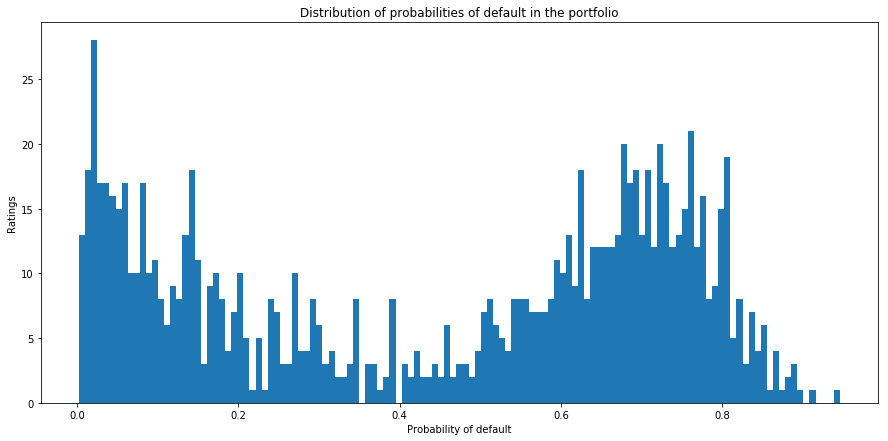

In [37]:
portfolio.show_pd_hist()

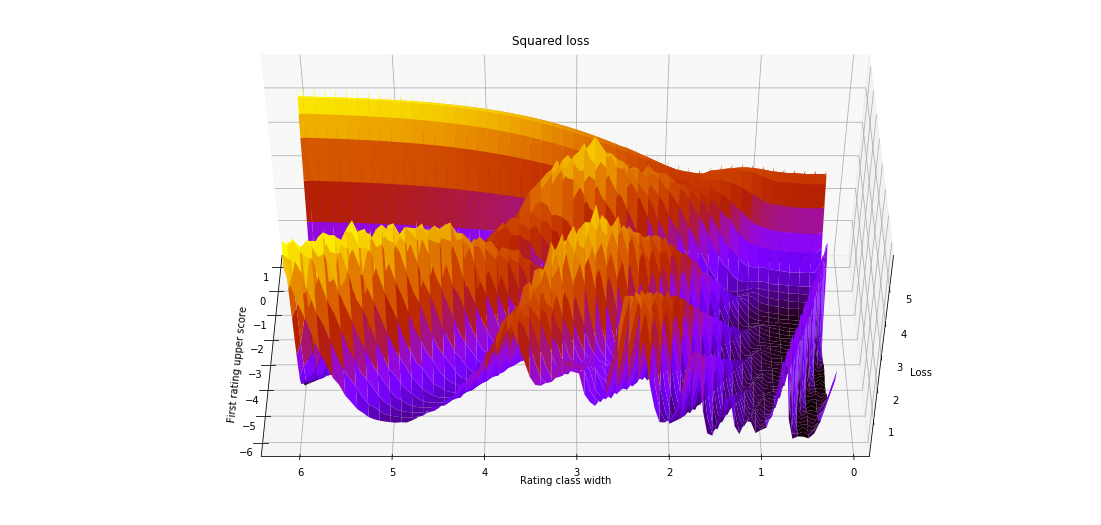

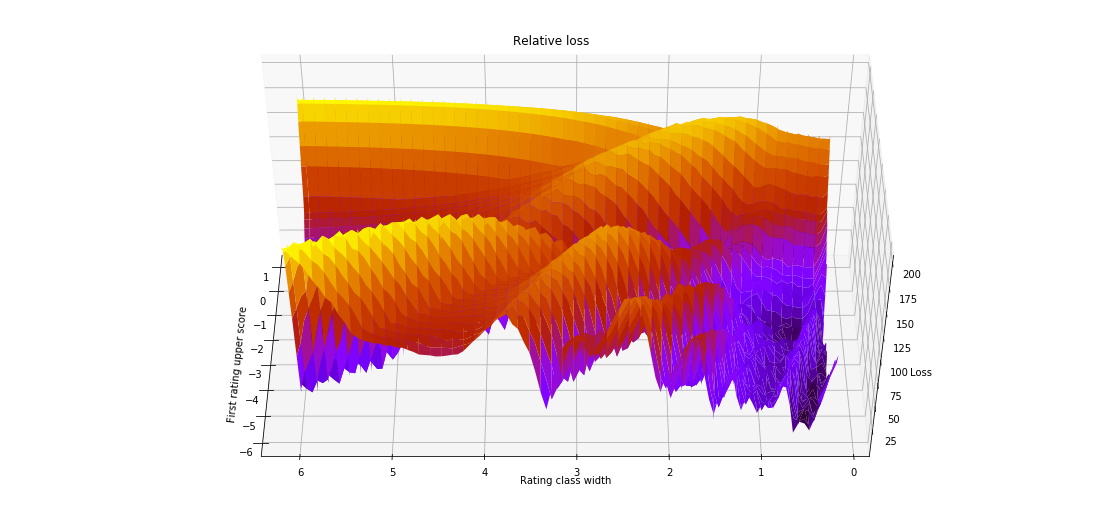

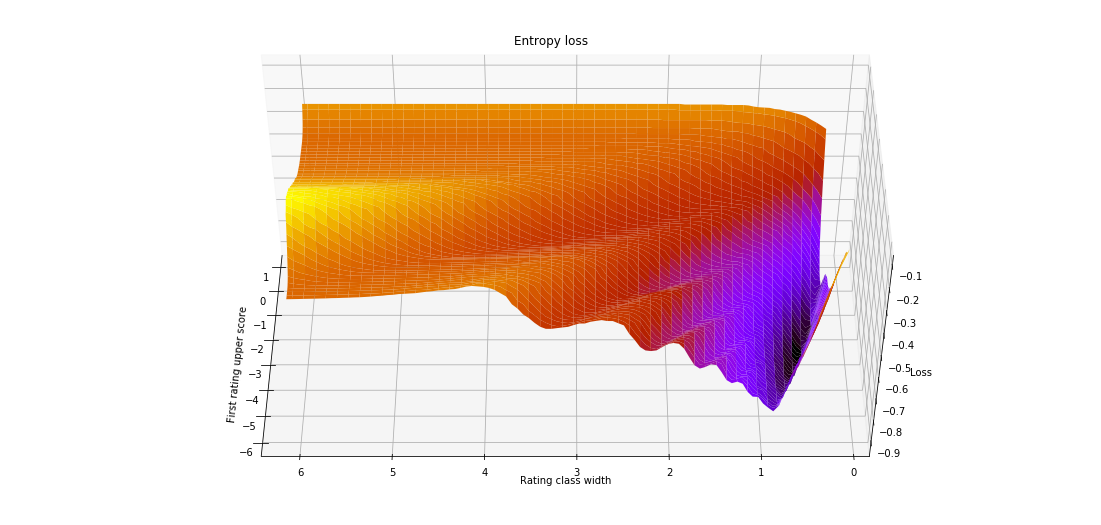

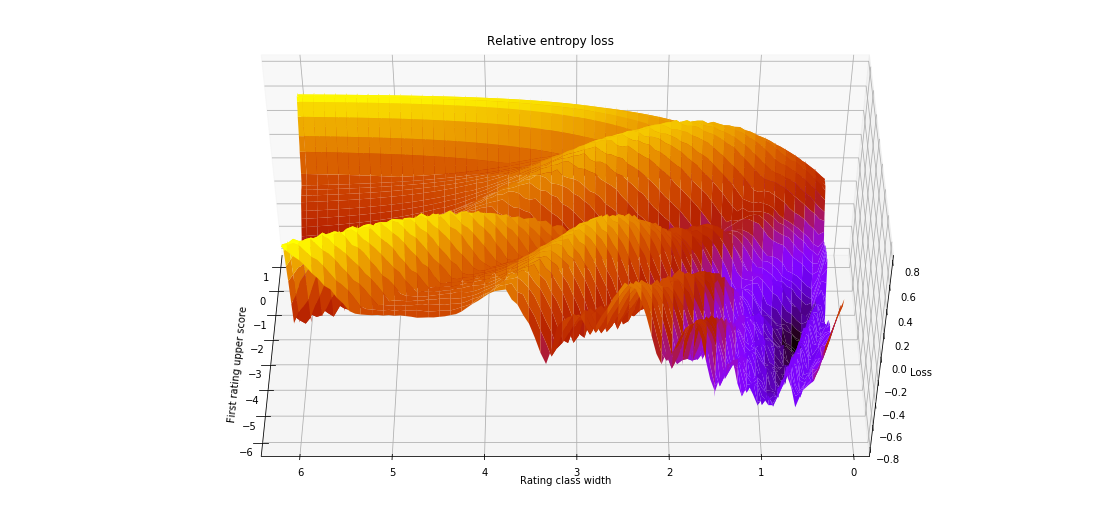

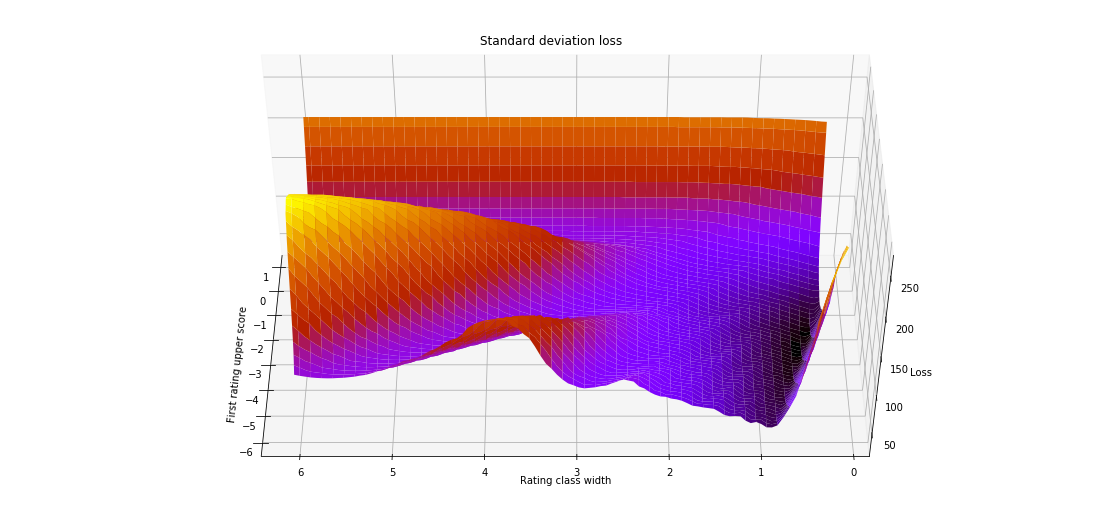

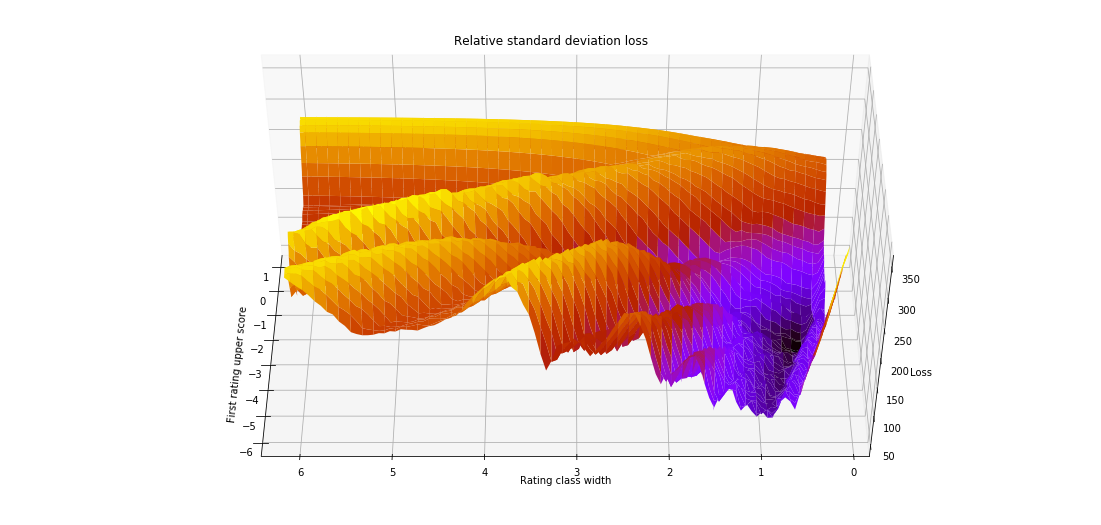

In [39]:
ranges = [[-6,1],[0.25,6]]
points = 100

for method in methods:    
    portfolio.show_parameter_space(ranges, points, method['lossfunc'], name=method['name'], title=method['title'], save=False);


## Optimizing all loss functions

In [42]:
np.random.seed(seed=201711)
portfolio = Portfolio(size=1000, pdfunc = pd_bimodal, classes = 10)

In [43]:
optim_start = [-3, 0.5]
common_loss = rel_loss

Squared loss


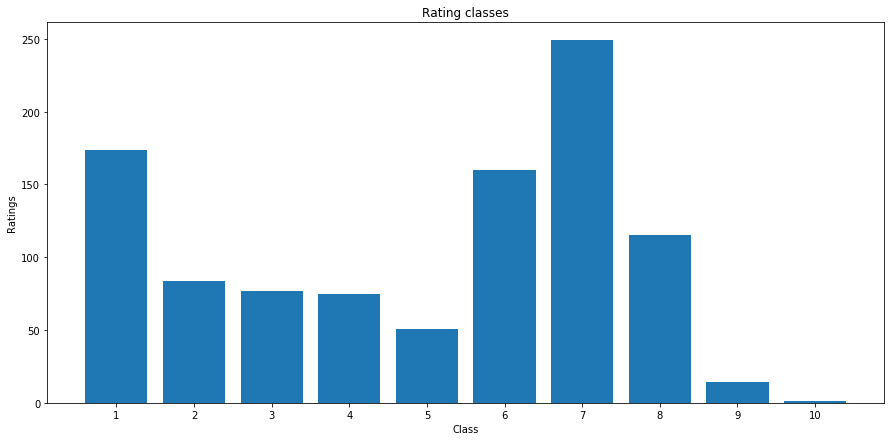

Relative loss


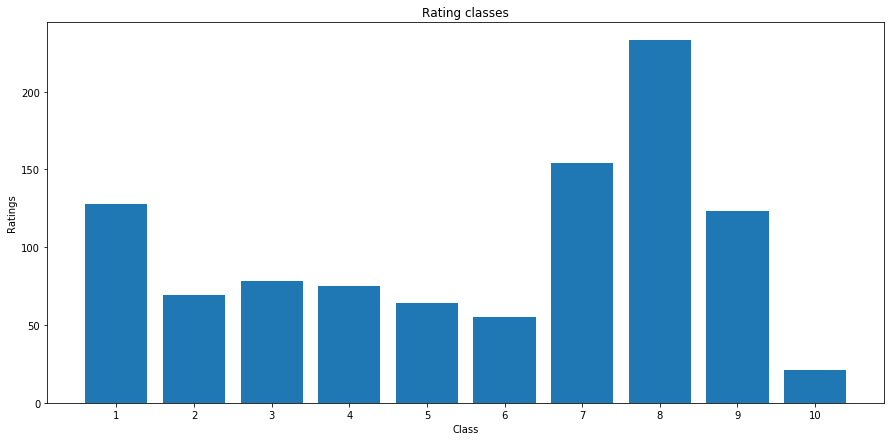

Entropy loss


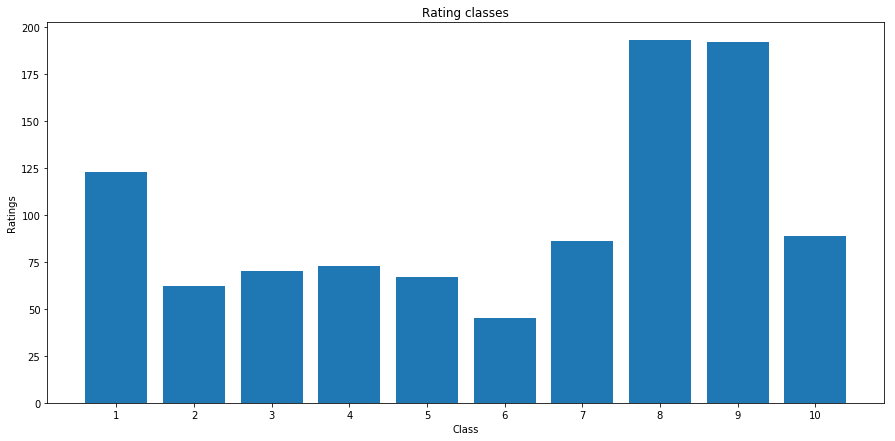

Relative entropy loss


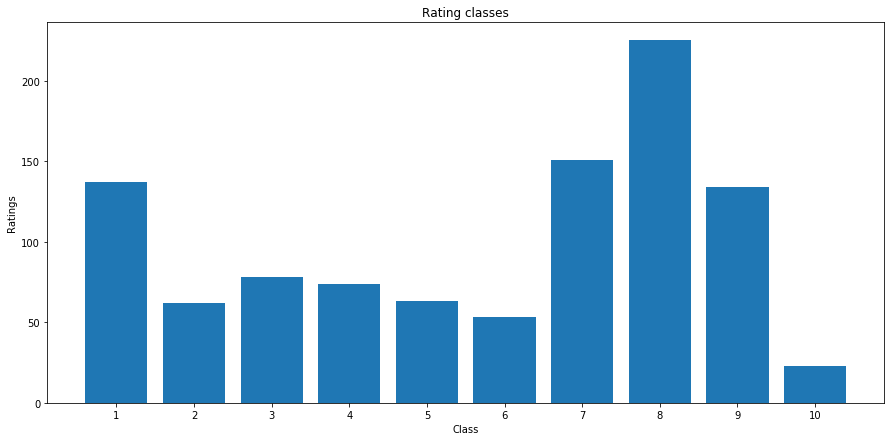

Standard deviation loss


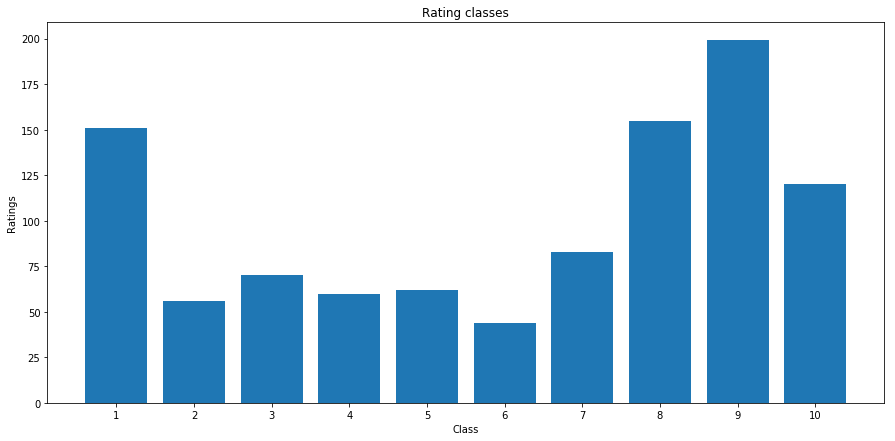

Relative standard deviation loss


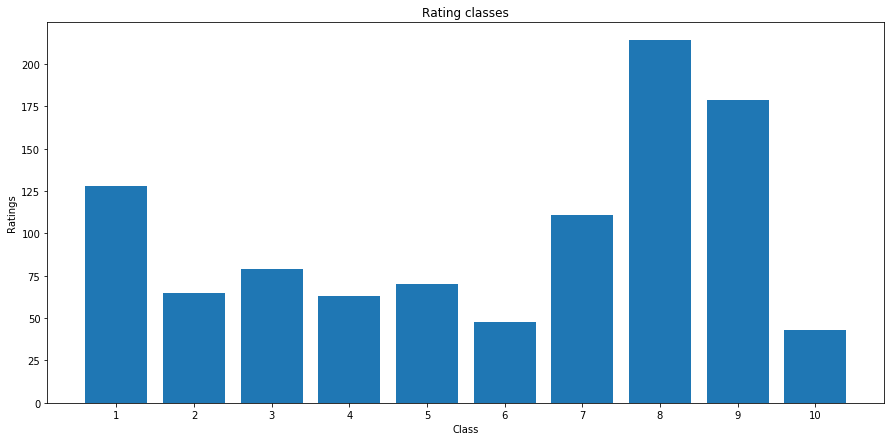

Loss function  Total common loss  Average variance  \
0                      Squared loss          17.843337          0.000977   
1                     Relative loss          10.324386          0.000832   
2                      Entropy loss          19.826302          0.000756   
3             Relative entropy loss          12.426704          0.000808   
4           Standard deviation loss          22.854572          0.000701   
5  Relative standard deviation loss          13.303252          0.000771   

   Total entropy  First class  Class width  
0       2.010596    -2.386528     0.593025  
1       2.142719    -2.779026     0.560206  
2       2.188661    -2.847057     0.521208  
3       2.143410    -2.734101     0.549868  
4       2.182923    -2.583627     0.473710  
5       2.164594    -2.779026     0.532356

In [44]:
optims_bim = portfolio.optimize_list(params = optim_start, methods = methods, common_loss = common_loss)
optims_bim

### Relative loss

In [45]:
portfolio.optimize(optim_start[0],optim_start[1],rel_loss)['fun']
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1    128       -inf  -2.779026  0.000000  0.058468  0.029234   
1       2     69  -2.779026  -2.218820  0.058468  0.098073  0.077133   
2       3     78  -2.218820  -1.658613  0.098073  0.159948  0.130612   
3       4     75  -1.658613  -1.098407  0.159948  0.250038  0.200704   
4       5     64  -1.098407  -0.538201  0.250038  0.368606  0.302604   
5       6     55  -0.538201   0.022005  0.368606  0.505501  0.440883   
6       7    154   0.022005   0.582211  0.505501  0.641576  0.581883   
7       8    233   0.582211   1.142417  0.641576  0.758123  0.700626   
8       9    123   1.142417   1.702623  0.758123  0.845877  0.793565   
9      10     21   1.702623        inf  0.845877  1.000000  0.873713   

   assigned_pd   class_var          loss  
0     0.029234  0.00021430  7.657740e-07  
1     0.078271  0.00014855  1.002744e+00  
2     0.129011  0.00023792  9.680630e-01  
3     0.204993  0.00074711  1.569179e+00  
4     0.309322  0.00098424  1.389958e+00  
5     0.437054  0.00170065  4.818474e-01  
6     0.573539  0.00152180  2.240488e+00  
7     0.699850  0.00106755  2.583788e-01  
8     0.802000  0.00054733  1.293680e+00  
9     0.922939  0.00060233  1.120047e+00

### Entropy loss

In [46]:
portfolio.optimize(optim_start[0],optim_start[1],entropy_loss)['fun']
portfolio.rating_table()

Rating  Count  min_score  max_score    min_pd    max_pd    avg_pd  \
0       1    123       -inf  -2.847057  0.000000  0.054834  0.028103   
1       2     62  -2.847057  -2.325848  0.054834  0.089005  0.072173   
2       3     70  -2.325848  -1.804640  0.089005  0.141287  0.119283   
3       4     73  -1.804640  -1.283432  0.141287  0.216967  0.175399   
4       5     67  -1.283432  -0.762224  0.216967  0.318164  0.269487   
5       6     45  -0.762224  -0.241016  0.318164  0.440036  0.377832   
6       7     86  -0.241016   0.280193  0.440036  0.569593  0.516454   
7       8    193   0.280193   0.801401  0.569593  0.690274  0.637699   
8       9    192   0.801401   1.322609  0.690274  0.789615  0.737387   
9      10     89   1.322609        inf  0.789615  1.000000  0.826062   

   assigned_pd   class_var      loss  
0     0.027417  0.00019021 -0.111942  
1     0.071919  0.00011495 -0.074872  
2     0.115146  0.00026335 -0.080843  
3     0.179127  0.00044988 -0.082977  
4     0.267565  0.00075215 -0.078653  
5     0.379100  0.00114905 -0.060605  
6     0.504815  0.00123242 -0.091633  
7     0.629934  0.00119151 -0.137887  
8     0.739945  0.00075960 -0.137606  
9     0.894808  0.00101341 -0.093504

## Comparison of rating metrics

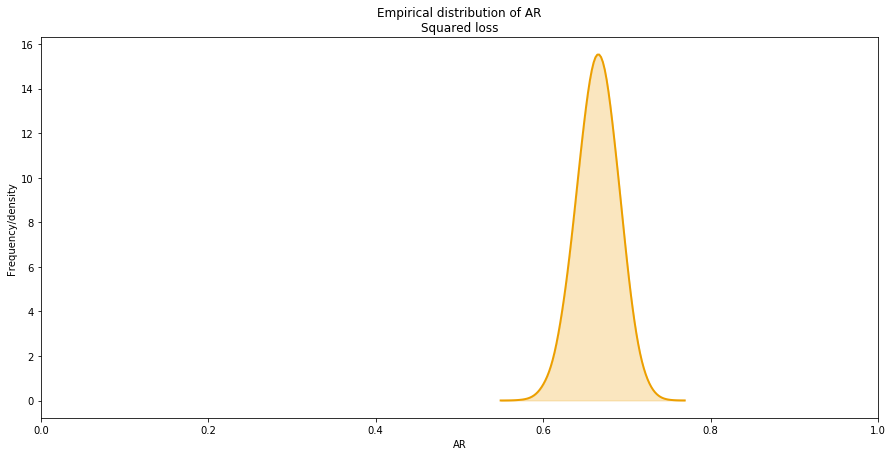

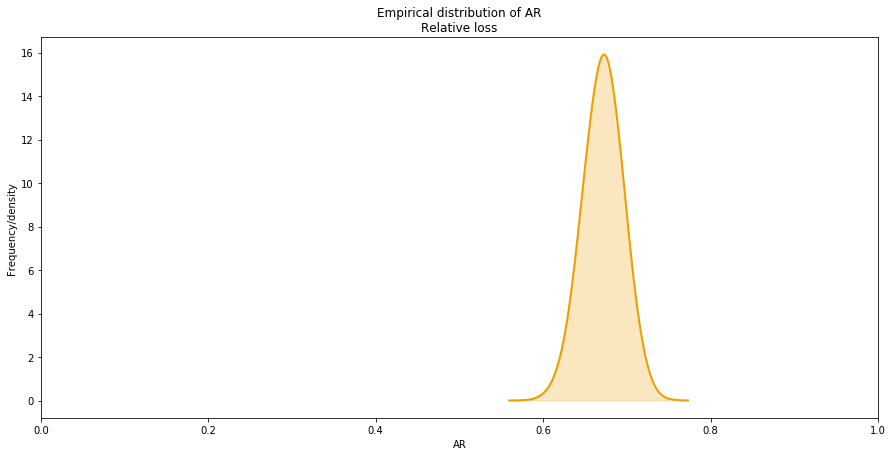

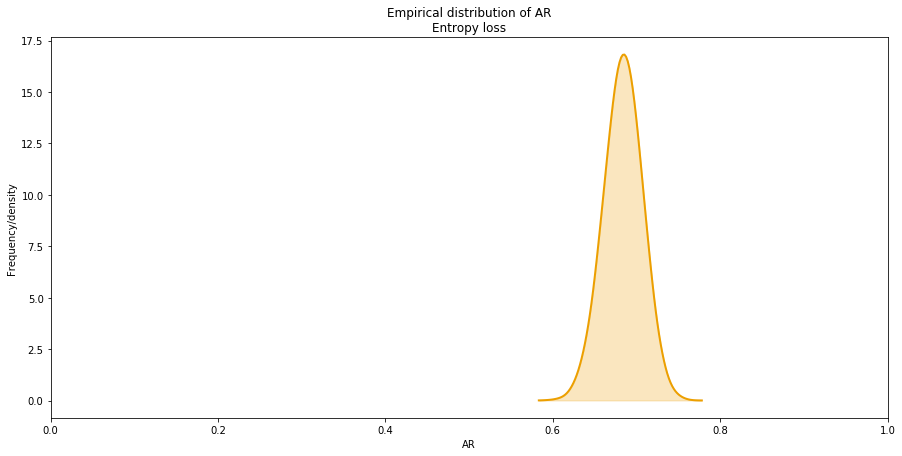

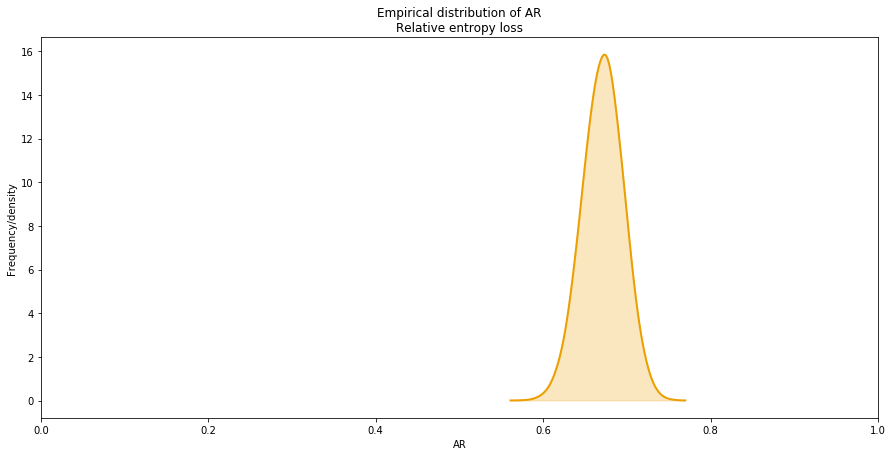

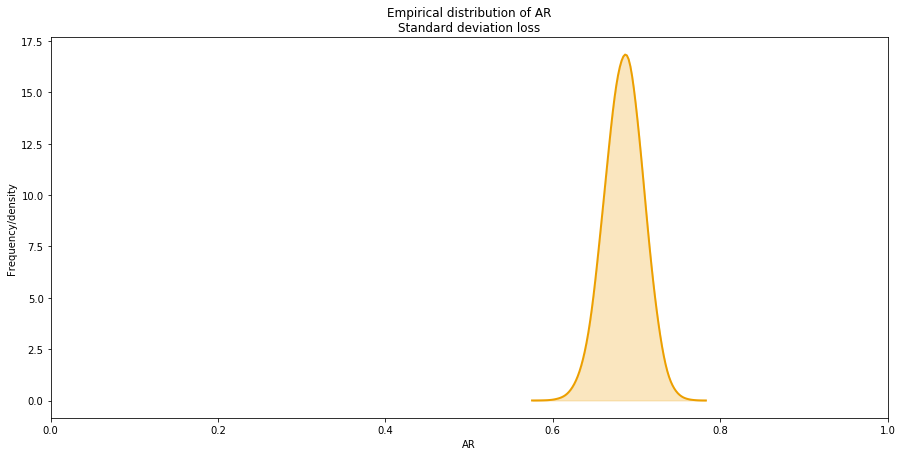

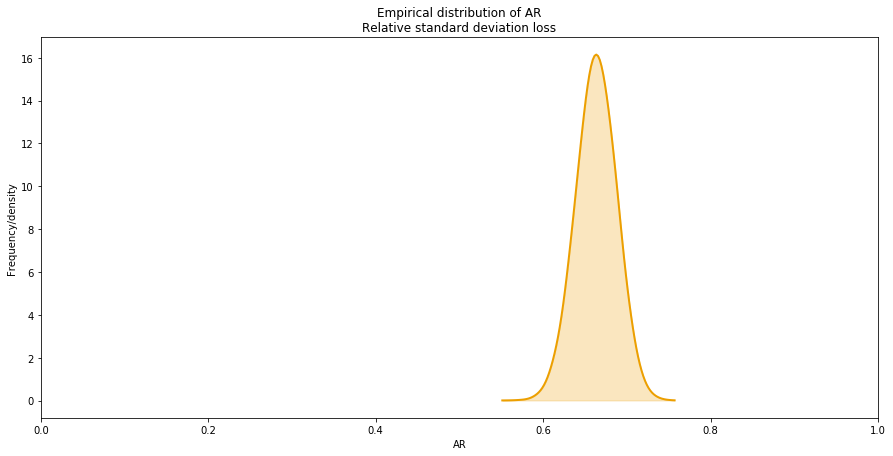

In [58]:
Scores = {}
for method in methods:        
    np.random.seed(seed=201711)
    portfolio = Portfolio(size=1000, pdfunc=pd_bimodal, classes = 10)
    
    params = optims_bim.loc[optims_sub['Loss function'] ==  method['title'],['First class', 'Class width']]
    portfolio.update_ratings(params.iloc[0,0],params.iloc[0,1], rel_loss)
    graph, summary = portfolio.simulate(iterations=iterations, subtitle=method['title'], rating_metrics=rating_metrics)
    Scores[method['title']] = {'graph': graph, 'summary': summary}

In [59]:
print("Accuracy ratio")
compare(Scores, "AR")

Accuracy ratio


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        0.664993       0.671521       0.683879               0.671340   
std         0.024911       0.024385       0.023112               0.024397   
min         0.549232       0.559545       0.583337               0.560978   
2.5%        0.615278       0.622773       0.637500               0.622438   
5%          0.623359       0.630905       0.645182               0.630683   
9.5%        0.632020       0.639281       0.653350               0.638999   
25%         0.648333       0.655215       0.668559               0.654953   
50%         0.665335       0.671899       0.684251               0.671811   
75%         0.682050       0.688164       0.699639               0.688025   
97.5%       0.712599       0.718243       0.728194               0.718173   
max         0.769106       0.772983       0.778065               0.769665   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  0.685075                          0.663346  
std                   0.022987                          0.024048  
min                   0.575255                          0.551191  
2.5%                  0.639207                          0.615433  
5%                    0.646926                          0.623478  
9.5%                  0.654779                          0.631655  
25%                   0.669743                          0.647314  
50%                   0.685491                          0.663526  
75%                   0.700728                          0.679747  
97.5%                 0.728973                          0.709462  
max                   0.782892                          0.757041

In [60]:
print("ROC")
compare(Scores, "ROC")

ROC


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        0.824299       0.827979       0.836616               0.828266   
std         0.012075       0.011875       0.011480               0.011874   
min         0.767778       0.773210       0.787945               0.774430   
2.5%        0.800134       0.804218       0.813622               0.804506   
5%          0.804157       0.808208       0.817380               0.808489   
9.5%        0.808335       0.812291       0.821429               0.812503   
25%         0.816233       0.820051       0.829013               0.820286   
50%         0.824452       0.828171       0.836815               0.828503   
75%         0.832576       0.836079       0.844424               0.836391   
97.5%       0.847344       0.850762       0.858581               0.851089   
max         0.874663       0.877366       0.882889               0.876194   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  0.839021                          0.829763  
std                   0.011475                          0.011820  
min                   0.785642                          0.775003  
2.5%                  0.816012                          0.806114  
5%                    0.819958                          0.810108  
9.5%                  0.823907                          0.814125  
25%                   0.831360                          0.821894  
50%                   0.839210                          0.829879  
75%                   0.846850                          0.837839  
97.5%                 0.860971                          0.852380  
max                   0.888136                          0.875364

In [61]:
print("Cross entropy")
compare(Scores, "Cross entropy")

Cross entropy


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        1.685042       1.646616       1.574965               1.651591   
std         0.027205       0.030079       0.035818               0.030009   
min         1.571517       1.515323       1.409140               1.528384   
2.5%        1.632106       1.588162       1.505409               1.593315   
5%          1.640353       1.597484       1.516198               1.602451   
9.5%        1.649362       1.607329       1.528137               1.612429   
25%         1.666582       1.626260       1.550838               1.631201   
50%         1.684865       1.646450       1.574781               1.651338   
75%         1.703441       1.666806       1.598882               1.671786   
97.5%       1.738441       1.706312       1.645513               1.711039   
max         1.808951       1.786098       1.737939               1.785555   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  1.620688                          1.605680  
std                   0.037020                          0.032533  
min                   1.465797                          1.465979  
2.5%                  1.548126                          1.542436  
5%                    1.560218                          1.552505  
9.5%                  1.572408                          1.563258  
25%                   1.595727                          1.583741  
50%                   1.620520                          1.605403  
75%                   1.645439                          1.627567  
97.5%                 1.693511                          1.669655  
max                   1.799803                          1.753848

In [62]:
print("Brier score")
compare(Scores, "Brier score")

Brier score


Squared loss  Relative loss   Entropy loss  Relative entropy loss  \
count  100000.000000  100000.000000  100000.000000          100000.000000   
mean        0.165758       0.164449       0.160830               0.164376   
std         0.005971       0.005925       0.005920               0.005921   
min         0.139810       0.139477       0.136229               0.140819   
2.5%        0.154283       0.153054       0.149513               0.152984   
5%          0.156053       0.154812       0.151233               0.154788   
9.5%        0.157984       0.156738       0.153116               0.156680   
25%         0.161663       0.160403       0.156802               0.160336   
50%         0.165666       0.164363       0.160746               0.164286   
75%         0.169754       0.168403       0.164756               0.168340   
97.5%       0.177661       0.176215       0.172678               0.176167   
max         0.193128       0.192395       0.187871               0.191782   

       Standard deviation loss  Relative standard deviation loss  
count            100000.000000                     100000.000000  
mean                  0.160046                          0.163733  
std                   0.005969                          0.005925  
min                   0.133779                          0.138870  
2.5%                  0.148598                          0.152418  
5%                    0.150362                          0.154135  
9.5%                  0.152281                          0.156035  
25%                   0.155962                          0.159671  
50%                   0.159959                          0.163666  
75%                   0.164033                          0.167682  
97.5%                 0.171968                          0.175544  
max                   0.189009                          0.193236

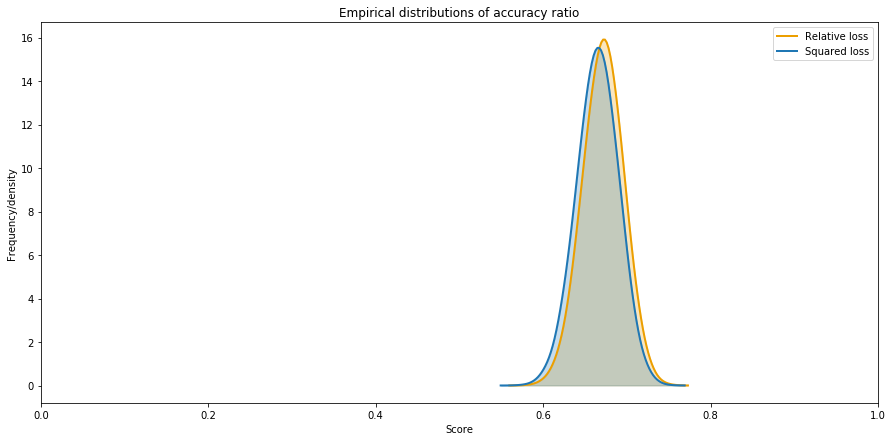

In [63]:
compare_graphs(Scores,['Relative loss', 'Squared loss'],"AR")

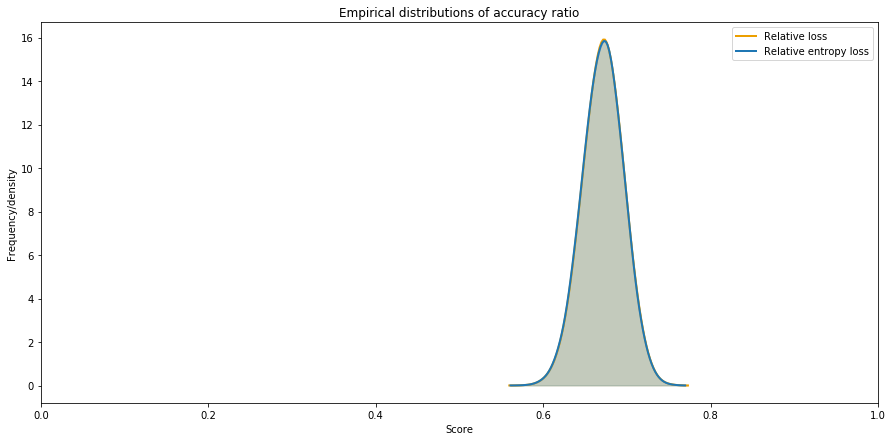

In [64]:
compare_graphs(Scores,['Relative loss', 'Relative entropy loss'],"AR")

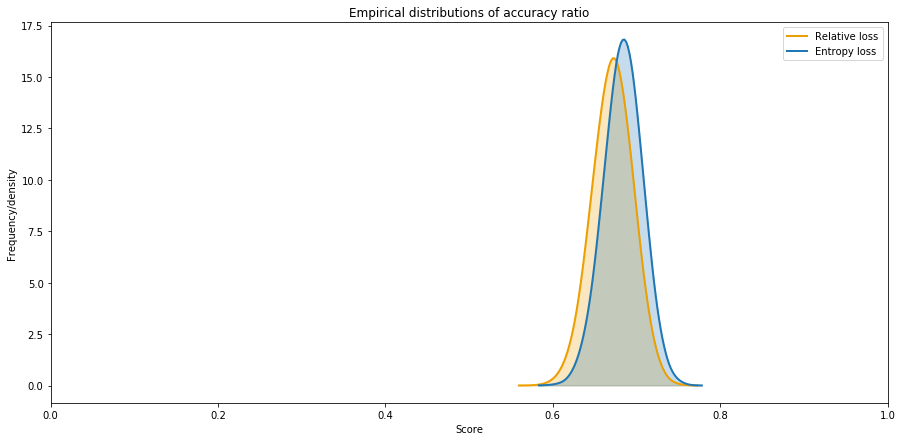

In [65]:
compare_graphs(Scores,['Relative loss', 'Entropy loss'],"AR")